# Applied Data Analysis: CMU Movie Summary Corpus

## Dataset Details
This dataset contains metadata and plot summaries for over 42,000 movies. The dataset is a rich resource for exploring relationships between movies, characters, and plot content.

- **Name**: CMU Movie Summary Corpus
- **Source**: [CMU Movie Summary Corpus Dataset](https://www.cs.cmu.edu/~ark/personas/)
- **Size**: 46 MB (compressed)
- **Typology**: Text + Graphs + Numerical Data
- **Tags**: Movies, Characters, Plot Summaries, Metadata

The dataset contains:
- **Movie Metadata**: Information about the movies such as titles, genres, release dates.
- **Character Metadata**: Details about the characters in each movie.
- **Plot Summaries**: Textual summaries of movie plots extracted from Wikipedia.

You can read more about the dataset in the paper: [Bamman et al., 2013](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

## Part 1 : Understanding the data
In this section, we will begin by loading the dataset and performing some initial exploratory data analysis (EDA). This will help us understand the structure and content of the data, identify any missing values, and get a sense of the distributions and relationships between different variables.

In [ ]:
# Imports
import importlib
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import src.utils.data_utils as data_utils
import src.utils.processings as processor
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

importlib.reload(CMU_dataset_dataloader)
importlib.reload(data_utils)
importlib.reload(processor)

# Constants
CMU_DATA_DOWNLOAD_PATH = 'https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
CMU_DATA_PATH_INITIAL = 'data/initial/'
CMU_DATA_PREPROCESSED_PATH = 'data/preprocessed/'

sns.set_palette("colorblind") 
sns.set_style("whitegrid")

### Load the plot summaries

In [6]:
print("Loading Plot Summaries...")

# Specify only the necessary columns for loading
categories = ['movie_id', 'summary']

# Load data
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=categories)
df_plots = plots.data

print("\nSample of Plot Summaries:")
display(df_plots.sample(5))

print("\nPlot Summaries Data Summary:")
print(df_plots.info())

# Check for missing values in 'summary' column
missing_values = df_plots['summary'].isnull().sum()
if missing_values > 0:
    print(f"\nWarning: There are {missing_values} missing values in the 'summary' column.")
else:
    print("\nNo missing values in the 'summary' column.")

Loading Plot Summaries...

Sample of Plot Summaries:


,movie_id,summary
11268,2410175,"In the mythical European city of Leisure, marr..."
6088,32986669,Key scenes of the film included the branding o...
38890,101899,"Four Atlanta businessmen, Lewis , Ed , Bobby ..."
40715,21119581,Inuk covers a journey from Greenland's south t...
13683,18965892,"Set in 1979 Syosset, Long Island, New York, Ly..."



Plot Summaries Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42303 non-null  int64 
 1   summary   42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB
None

No missing values in the 'summary' column.


### Plot summaries preprocessing

count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64


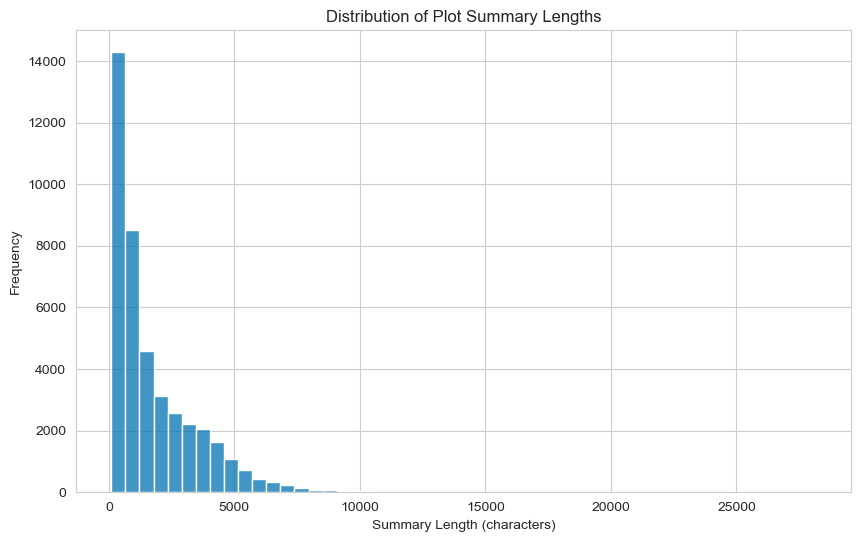

       movie_id                                            summary  \
31067   3204413  Having seen the relationship between Snoopy an...   
3026   10141649  After the death of his dad, Dayashankar Pandey...   
34731   2354153  The film begins with a succession of real-life...   
23131    244897  On October 31, 1998, Eric Bottler reunites wit...   
18452     23255  The film begins with a voiceover describing th...   

       summary_length  
31067            1366  
3026              590  
34731            4681  
23131            5117  
18452            5828  


In [7]:
processor.process_plot_summaries(df_plots)

### Load the movie metadata

In [ ]:
# Load the movie metadata
print("\nLoading Movie Metadata...")

categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
]

movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data

print("\nSample of Movie Metadata:")
display(df_movies.sample(5))

print("\nData Summary:")
print(df_movies.info())

missing_values = df_movies.isnull().sum()
print("\nMissing Values by Column:")
print(missing_values[missing_values > 0])


Loading Movie Metadata...

Sample of Movie Metadata:


,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
15251,31134678,/m/0gh7cf9,White Face,1932-05,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."
34328,28889048,/m/0ddchqj,Hubertus Castle,1934,NaN,85.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
21511,1471253,/m/054476,McLintock!,1963-11-13,NaN,127.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3mzj"": ..."
77077,28492902,/m/0crd3j4,Cashier Wants to Go to the Seaside,2001-11-13,NaN,86.0,"{""/m/0k0sv"": ""Croatian language"", ""/m/0k0sb"": ...","{""/m/01pj7"": ""Croatia""}","{""/m/05p553"": ""Comedy film""}"
4618,14356448,/m/03d1j4k,Der Hauptmann von Köpenick,1956,NaN,93.0,"{""/m/04306rv"": ""German Language""}","{""/m/082fr"": ""West Germany""}","{""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy""}"



Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wikipedia_movie_id  81741 non-null  int64  
 1   freebase_movie_id   81741 non-null  object 
 2   movie_name          81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB
None

Missing Values by Column:
release_date           6902
box_office_revenue    73340
runtime               20450
dtype: int64


As we can see here, there are is a lot of data which is not directly workable. The only way to go: preprocessing.

### Movie metadata preprocessing

Since our main goal is to predict the box office revenue of the movies, movies with missing revenue values will be removed from the dataset. We will also remove the freebase_movie_id column as it is not relevant for our analysis.

Within the release date column there is important information that can be separated: Day, Month, and Year. Specific months and years can be crucial for box office revenue.

When we print of the years in our dataset, we can notice that there is a big gap between the first year and the following ones (1010 - 1897 - 1914). This also serves to highlight the importance of preprocessing, as it is obvious that there was no movie made in 1010. To avoid this type of outliers (and errors), we will only consider films from 1900 onwards.

Specifically for genres, we can notice that sometimes one can be divided into two, and other times two genres mean the same genre. For example, a film with the genre 'Action/Adventure' can be associated with both Action and Adventure; The genres 'Superhero movie' and 'Superhero' which end up being the same. For this reason, the function `create_genre_list` was created to do preprocessing that divides/unites this type of cases.

In [73]:
df_movies = processor.process_movie_metadata(df_movies)

Genres : 0                      Thriller
0               Science Fiction
0                        Horror
0                     Adventure
0                  Supernatural
                  ...          
81726    Psychological thriller
81726            Crime Thriller
81726           Courtroom Drama
81732               Comedy film
81732                     Drama
Name: genres, Length: 39880, dtype: object 


        wikipedia_movie_id                            movie_name  \
75618            24217848                      There Be Dragons   
18723             3025805                              Undertow   
48598             6642278  The Life and Times of Judge Roy Bean   
18049             2441439                     Two Moon Junction   
20104             3394318                 Death Before Dishonor   

       box_office_revenue  runtime                           languages  \
75618           4372642.0    122.0  {'/m/02h40lc': 'English Language'}   
18723            143597.0    108.0  {'/m/

### Load the character metadata

In [34]:
print("\nLoading Character Metadata...")

categories = [
    'wikipedia_movie_id', 
    'freebase_movie_id', 
    'release_date', 
    'character_name', 
    'actor_birth', 
    'actor_gender', 
    'actor_height', 
    'actor_ethnicity', 
    'actor_name', 
    'actor_age', 
    'freebase_character_actor_id', 
    'freebase_character_id', 
    'freebase_actor_id'
]

characters = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'character.metadata.tsv', categories=categories)
df_characters = characters.data

print("\nSample of Character Metadata:")
display(df_characters.sample(5))

print("\nCharacter Metadata Data Summary:")
print(df_characters.info())

missing_values = df_characters.isnull().sum()
print("\nMissing Values by Column:")
print(missing_values[missing_values > 0])

print("\nUnique values in 'actor_gender':", df_characters['actor_gender'].unique())
print("Unique values in 'actor_ethnicity':", df_characters['actor_ethnicity'].unique())


Loading Character Metadata...

Sample of Character Metadata:


,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_id,freebase_character_id,freebase_actor_id
13413,31129842,/m/0gh84lj,2011,Sejal,NaN,F,NaN,NaN,Girija Oak,NaN,/m/0h6n1k3,/m/0h6n1k5,/m/0gc52qj
369747,28014469,/m/0ch306m,2010-10-06,NaN,1976-05-07,F,NaN,NaN,Zoé Félix,34.0,/m/0chblrl,NaN,/m/02610l4
57823,17776794,/m/047dkn5,2009-01-16,Carlo,1959-06-30,M,1.93,NaN,Vincent D'Onofrio,49.0,/m/08n4l7b,/m/08n4l7f,/m/01hmb_
122050,11590938,/m/02rknss,2005-04-09,Conan Edogawa,1964-05-05,F,NaN,NaN,Minami Takayama,40.0,/m/040hvl7,/m/04lcmxp,/m/01vs8ng
102588,6883275,/m/0gv4n1,1960,Amanda Dell,1926-06-01,F,1.66,/m/04f581,Marilyn Monroe,33.0,/m/02vcg7n,/m/0gxt02s,/m/04wqr



Character Metadata Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   wikipedia_movie_id           450669 non-null  int64  
 1   freebase_movie_id            450669 non-null  object 
 2   release_date                 440674 non-null  object 
 3   character_name               192794 non-null  object 
 4   actor_birth                  344524 non-null  object 
 5   actor_gender                 405060 non-null  object 
 6   actor_height                 154824 non-null  float64
 7   actor_ethnicity              106058 non-null  object 
 8   actor_name                   449441 non-null  object 
 9   actor_age                    292556 non-null  float64
 10  freebase_character_actor_id  450669 non-null  object 
 11  freebase_character_id        192804 non-null  object 
 12  freebase_actor_id       

### Character metadata preprocessing

In the character.metadata dataset, the most relevant information for this study resides in the characteristics of the actors. In order to work on it and study its relevance for box office revenue, it is necessary to add revenue to this information, and keep only the relevant columns.

In the dataset, the ethnicity is represented by the freebase id, which at first glance is not clear what it refers to. A search that replaces the ids with their name is then performed.

We can also notice that there are many ethnicities like "Asian American" that, as was done with the movie genre, can be separated. For this reason, we will preprocess this column with the function `create_ethnicity_list`.

In [37]:
# Merge the character dataframe with the movie dataframe
df_actors_revenues = processor.process_character_metadata(df_characters, df_movies)

Ethnicities:
African Americans
Omaha Tribe of Nebraska
Jewish people
Irish Americans
Indian Americans
Italians
German Americans
Indians
Ezhava
Malayali
Taiwanese people
Armenians
Marathi people
Lithuanian Americans
Black people
Italian Americans
Danish Americans
American Jews
Scottish Americans
Puerto Ricans
English people
Irish people
European Americans
Russian Americans
English Americans
Gujarati people
Spanish Americans
Bihari people
Nair
Cuban Americans
White people
Canadian Americans
Russians
British Nigerian
Yoruba people
Japanese people
Scandinavian Americans
Filipino Americans
Swedish Americans
Finnish Americans
Koreans
French
Welsh people
White Americans
Bengali
Uruguayans
Iranian peoples
Mexicans
Dutch Americans
Hungarian Americans
Spaniards
Gaud Saraswat Brahmin
Bunt (RAJPUT)
Afghans in India
Hispanic and Latino Americans
Swedes
Sindhis
Tamil
Italian Canadians
Asian Americans
Guyanese Americans
Mexican Americans
Japanese Americans
Punjabis
Bengali Hindus
Kanyakubja Brahmins


## Part 2 : Exploratory Data Analysis to answer basic per-fearture's questions

This part aims to investigate how each feature that we find as being individually important is impacting the box office revenue. For that, we will answer the following questions :
1. Release Season
    - How does **_release season_** correlate with box office revenue? Do films realeased in a specific season (e.g., summer, winter holiday, other) tend to perform better?
2. Genre
    - Which **_film genres_** have the highest average box office revenue? Are there genres that perform better than others?
3. Runtime
    - How does **_film runtime_** correlate with box office revenue? Do longer or shorter films tend to perform better?
4. Languages
    - How does **_film languages_** impact the box office revenue? Which languages have the highest average box office revenue?
5. Actors
    - Which **_actors_** appear in the films with the highest box office revenue? Does the presence of a specific actor influence box office revenue?

    1. Actors Age
        - What is the average box office revenue by **_actors' age group_** (child, teen, young adult, adult and senior)?
    2. Actors Gender
        - Does the **_gender distribution of actors_** in a film influence its average box office revenue?
        - What is the average box office revenue based on the **_gender predominance_** in the movie cast?
    3. Actors Ethnicity
        - What is the average box office revenue based on the **_ethnic diversity_** in the movie cast?
        - Does the **_ethnicity of the actors_** impact average box office revenue? Which ethnicities have the highest average box office revenue?
6. Evolution over time
    - How did **box office revenue** evolved over time? How was it for each **_genre_**?
    - How has **_runtime_** changed along the years and how it correlates with revenue?
7. Plot summary's sentiment
    - Are there specific schemes regarding the sentiment(s) presen in the summary of success movies ?
    - Is the dominant balance of feelings of a plot summary influence its success ?

### 1. Release Season
#### How does **_release season_** correlate with box office revenue? Do films realeased in a specific season (e.g., summer, winter holiday, other) tend to perform better?
- Display average box office revenue by release season (summer, winter holiday, other).

Average Box Office Revenue by Release Season:
release_season
Holiday    5.072250e+07
Other      3.992808e+07
Summer     7.458073e+07
Name: mean, dtype: float64


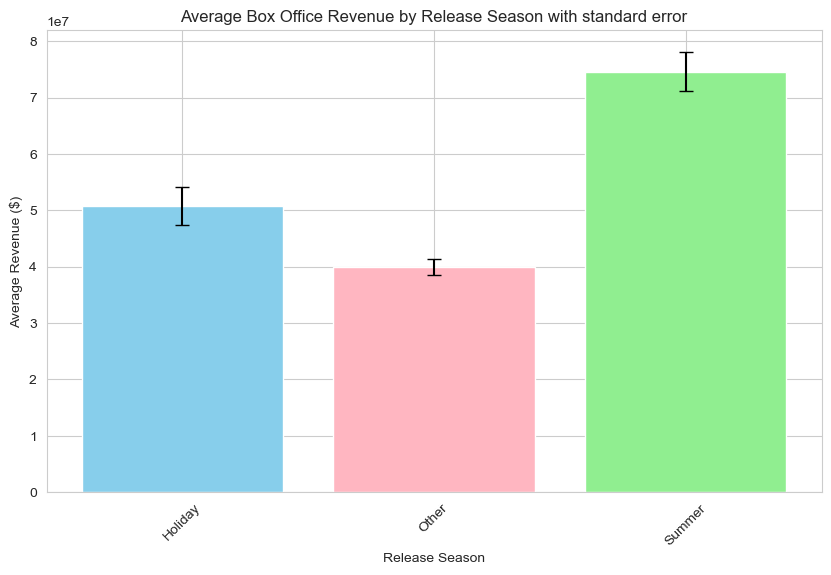

In [10]:
df_movies['release_season'] = df_movies['release_month'].apply(data_utils.categorize_release_season)

season_stats = df_movies.groupby('release_season')['box_office_revenue'].agg(['mean', 'sem'])

print("Average Box Office Revenue by Release Season:")
print(season_stats['mean'])

plt.figure(figsize=(10, 6))
plt.bar(season_stats.index, season_stats['mean'], yerr=season_stats['sem'], color=['skyblue', 'lightpink', 'lightgreen'], capsize=5)
plt.title('Average Box Office Revenue by Release Season with standard error')
plt.xlabel('Release Season')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis of Average Box Office Revenue by Release Season

The results indicate the following average revenues:

- **Holiday**: $50.72 million
- **Summer**: $74.58 million
- **Other**: $39.93 million

##### Observations

1. **Higher revenue in summer**: Movies released during the summer tend to have more revenue than films released during other times. This could be due to several reasons, for example, people having more free time, or there being a higher marketing effort for these movies since there will be a bigger audience a priori, between many others. 

2. **Lower revenue for other seasons**: Films released outside the summer and holiday months have an average revenue of about $39.93 million, noticeably lower than those released during peak seasons.

### 2. Genre
#### Which **_film genres_** have the highest average box office revenue? Are there genres that perform better than others?
- Display highest average box office revenue by genre (of the most 20 relevante genres).

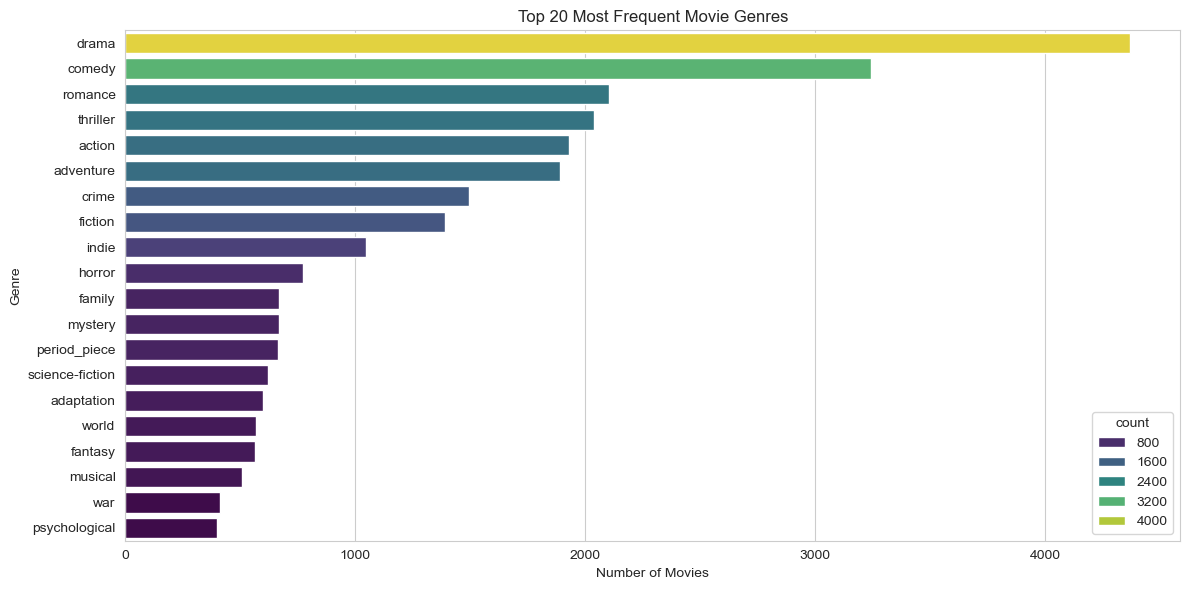

In [11]:
genre_counts = df_movies['genres'].explode().value_counts()

genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
top_genres = genre_counts_df.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, y='genre', x='count', hue='count', palette="viridis")
plt.title('Top 20 Most Frequent Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Average Box Office Revenue by Top 20 Genres:
                         mean           sem
genres                                     
fantasy          1.220199e+08  9.585742e+06
science-fiction  1.083780e+08  8.485672e+06
adventure        8.648948e+07  3.982014e+06
action           8.308088e+07  3.830586e+06
family           7.450184e+07  5.376374e+06
thriller         6.853330e+07  2.946463e+06
mystery          5.808759e+07  4.462343e+06
adaptation       5.488355e+07  4.756878e+06
fiction          5.140678e+07  2.953074e+06
war              4.819004e+07  4.535190e+06
crime            4.720055e+07  2.307257e+06
horror           4.680759e+07  3.181837e+06
psychological    4.516403e+07  4.099746e+06
period_piece     4.502928e+07  4.411531e+06
comedy           4.335669e+07  1.511968e+06
romance          4.146475e+07  2.007986e+06
drama            3.928705e+07  1.428636e+06
musical          2.942948e+07  3.170855e+06
world            1.810928e+07  1.649153e+06
indie            1.361580e+07  

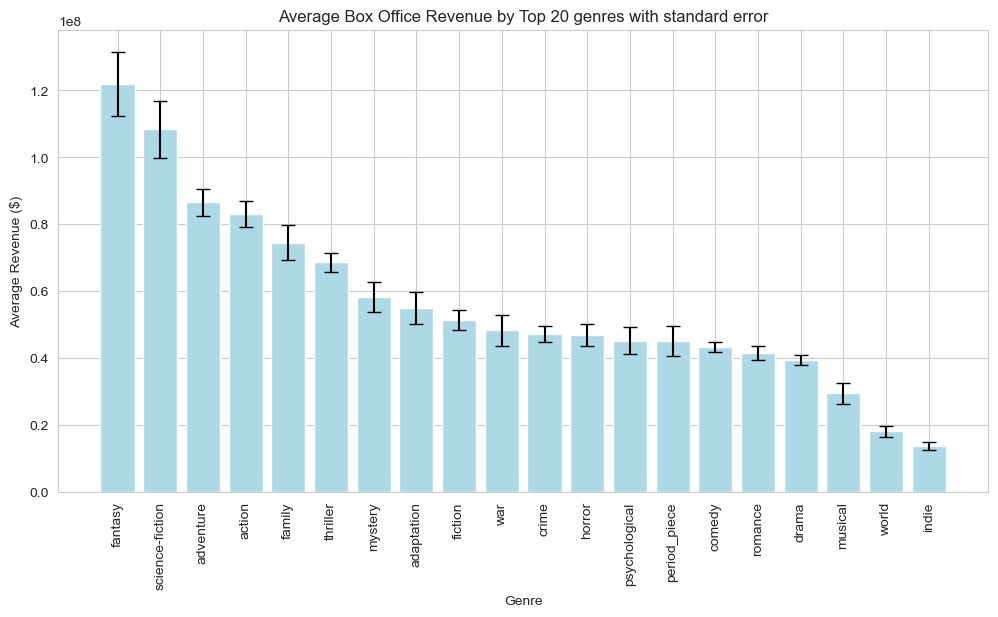

In [12]:
genre_stats = df_movies.explode('genres').groupby('genres')['box_office_revenue'].agg(['mean', 'sem'])

genre_stats = genre_stats[genre_stats.index.isin(top_genres['genre'])]

genres_revenue = genre_stats.sort_values(by='mean', ascending=False)

print("Average Box Office Revenue by Top 20 Genres:")
print(genres_revenue)

plt.figure(figsize=(12, 6))
plt.bar(genres_revenue.index, genres_revenue['mean'], yerr=genres_revenue['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Top 20 genres with standard error')
plt.xlabel('Genre')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=90)
plt.show()

#### Analysis of Average Box Office Revenue by Genre
The results indicate the following top average revenues by genre:

- **Fantasy**: $122.02 million
- **Science Fiction**: $108.38 million
- **Adventure**: $86.49 million
- **Action**: $83.08 million

##### Observations
1. **Highest revenue for fantasy and science fiction films**: Fantasy and then science-fiction films have the highest average. This is interesting to notice since there are several similarities between them.

2. **Broad popularity of adventure and action films**: Adventure and action films, come after, and they are also genres commonly seen together


### 3. Runtime
#### How does **_film runtime_** correlate with box office revenue? Do longer or shorter films tend to perform better?
- Analyze revenue by runtime to see if longer or shorter films tend to perform better.

Average Box Office Revenue by Runtime Category:
runtime_category
Short     3.125696e+07
Medium    3.876583e+07
Long      7.823741e+07
Name: mean, dtype: float64

Runtime definitions based on quantiles:
- Short: ≤ 96.0 minutes
- Medium: 97.0-110.0 minutes
- Long: > 111.0 minutes


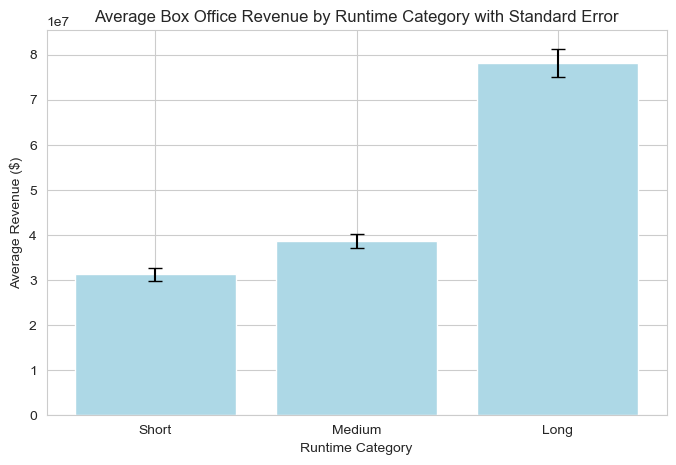

In [13]:
df_movies['runtime_category'] = pd.qcut(df_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])

short_max = df_movies[df_movies['runtime_category'] == "Short"]['runtime'].max()
medium_min = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].min()
medium_max = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].max()
long_min = df_movies[df_movies['runtime_category'] == "Long"]['runtime'].min()

runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])

print("Average Box Office Revenue by Runtime Category:")
print(runtime_stats['mean'])
print(f"\nRuntime definitions based on quantiles:\n- Short: ≤ {short_max} minutes\n- Medium: {medium_min}-{medium_max} minutes\n- Long: > {long_min} minutes")

plt.figure(figsize=(8, 5))
plt.bar(runtime_stats.index, runtime_stats['mean'], yerr=runtime_stats['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Runtime Category with Standard Error')
plt.xlabel('Runtime Category')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=0)
plt.show()

#### Analysis of Average Box Office Revenue by Film Runtime

The runtime categories, divided into equal-sized groups based on quantiles, are defined as follows:

- **Short Films**: Runtime of 96 minutes or less
- **Medium Films**: Runtime between 97 and 110 minutes
- **Long Films**: Runtime greater than 111 minutes

The average box office revenues based on these runtime categories are as follows:

- **Short Films**: $31.26 million
- **Medium Films**: $38.77 million
- **Long Films**: $78.21 million

##### Observations

1. **Significantly higher revenue for longer films**: Films with a runtime over 111 minutes ("Long") have a considerably higher average revenue, nearly double that of medium-length films and more than double that of short films. This suggests that audiences may be more inclined to invest in longer, more immersive film experiences.

2. **Lower revenue for short films**: Films with runtimes of 96 minutes or less ("Short") yield the lowest average revenue.

### 4. Languages
#### How does **_film languages_** impact the box office revenue? Which languages have the highest average box office revenue?
- Display highest 10 average box office revenue by language.

In [14]:
df_movies['all_languages'] = df_movies['languages'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

df_languages = df_movies.explode('all_languages')

language_counts = df_languages['all_languages'].value_counts()
print("Number of Movies by language:")
print(language_counts)

Number of Movies by language:
English Language                 7387
French Language                   534
Spanish Language                  427
German Language                   266
Korean Language                   251
                                 ... 
Korean Sign Language                1
Kinyarwanda language                1
Luxembourgish language              1
Napoletano-Calabrese Language       1
Standard Tibetan                    1
Name: all_languages, Length: 143, dtype: int64


Average Box Office Revenue by Top 10 Languages:
                             mean           sem  count
all_languages                                         
Latin Language       1.390445e+08  2.685478e+07     49
Portuguese Language  1.193924e+08  2.735045e+07     45
Russian Language     1.115866e+08  1.704854e+07    186
Arabic Language      1.045101e+08  1.536502e+07     81
Hebrew Language      1.011653e+08  2.350782e+07     46
Spanish Language     9.008994e+07  9.549400e+06    427
Italian Language     8.977924e+07  1.228346e+07    239
Standard Mandarin    8.741543e+07  1.366029e+07    117
German Language      8.657641e+07  1.077494e+07    266
French Language      8.292300e+07  7.269103e+06    534


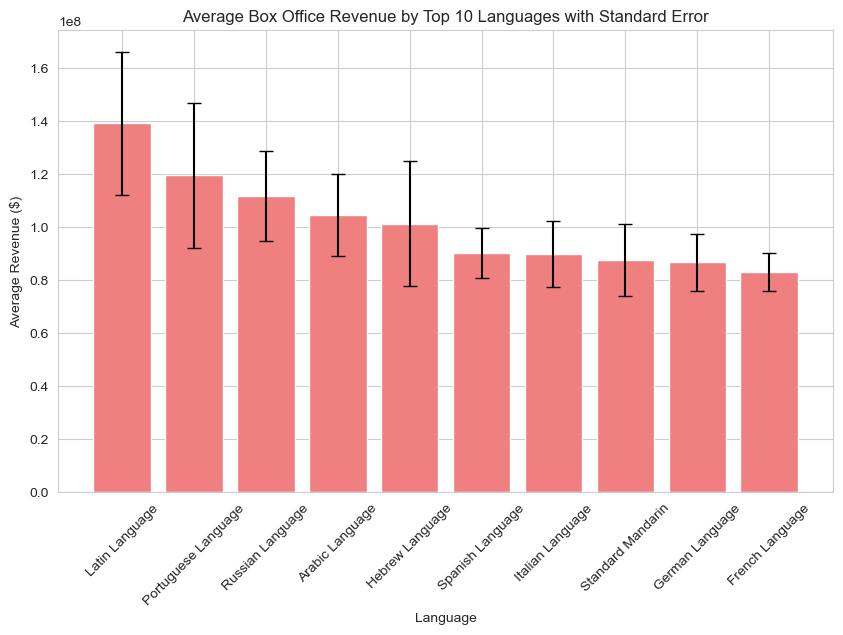

In [15]:
# Calculate average revenue, standard error and count by primary language
language_stats = df_languages.groupby('all_languages')['box_office_revenue'].agg(['mean', 'sem', 'count'])

# We filter out the statistically irrelevant languages
language_stats = language_stats[language_stats['count'] >= 30]

# Select the top 10 languages with the highest average revenue
top_10_languages = language_stats.sort_values(by='mean', ascending=False).head(10)

# Print the average revenue by language
print("Average Box Office Revenue by Top 10 Languages:")
print(top_10_languages)

# Plot the average revenue by language
plt.figure(figsize=(10, 6))
plt.bar(top_10_languages.index, top_10_languages['mean'], yerr=top_10_languages['sem'], color='lightcoral', capsize=5)
plt.title('Average Box Office Revenue by Top 10 Languages with Standard Error')
plt.xlabel('Language')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis of Average Box Office Revenue by Language

As we can see the standard error is very high, leading us to not draw any hasty conclusion. 

### 5. Actors
#### Which **_actors_** appear in the films with the highest box office revenue? Does the presence of a specific actor influence box office revenue?
- Display the 10 actors with highest box office revenue

In [16]:
# Count the number of movies for each actor
actors_count = df_actors_revenues['actor_name'].value_counts()
actors_count = actors_count[actors_count >= 20]

# Keep only actors with at least 20 movies
relevant_characters = df_actors_revenues[df_actors_revenues['actor_name'].isin(actors_count.index)]

# calculate the average revenue for each actor
actors_revenues = relevant_characters.groupby('actor_name')['box_office_revenue'].mean()

# Create a dataframe with the average revenue and number of movies for each actor
df_actors_info = pd.DataFrame({
    'mean_revenue': actors_revenues,
    'n_movies': actors_count
})

# Print the top 10 actors by average revenue
print("Top 10 Actors by Average Box Office Revenue:")
df_actors_info.sort_values(by='mean_revenue', ascending=False).head(10)

Top 10 Actors by Average Box Office Revenue:


,mean_revenue,n_movies
Hugo Weaving,3.706721e+08,24
Alan Rickman,3.520243e+08,29
Robbie Coltrane,3.364884e+08,30
Maggie Smith,3.200121e+08,29
John Rhys-Davies,3.135264e+08,20
Richard Griffiths,3.086754e+08,21
Will Smith,3.083475e+08,20
Helena Bonham Carter,3.022026e+08,26
Christopher Lee,2.943084e+08,25
Jason Isaacs,2.824248e+08,26


#### Analysis of Average Box Office Revenue by Actor

The average box office revenues based on the primary actors in the films are as follows:

- **Hugo Weaving**: $370.67 million
- **Alan Rickman**: $352.02 million
- **Robbie Coltrane**: $336.49 million
- **Maggie Smith**: $320.01 million
- **John Rhys-Davies**: $313.53 million
- **Richard Griffiths**: $308.68 million
- **Will Smith**: $308.35 million
- **Helena Bonham Carter**: $302.20 million
- **Christopher Lee**: $294.31 million
- **Timothy Spall**: $293.07 million

##### Observations

1. **Top performers with strong box office returns**: Actors like **Hugo Weaving**, **Alan Rickman**, and **Robbie Coltrane** lead in average box office revenue, all exceeding $330 million. This can in part be attributed to their roles in highly successful franchises such as *The Lord of the Rings* and *Harry Potter*, where it is unclear if the film benefited the actor or the other way around, or maybe both.

2. **Strong performances by veteran actors**: Many of the top actors, including **Maggie Smith**, **John Rhys-Davies**, and **Richard Griffiths**, have strong box office returns, likely due to their consistent roles in large franchises, particularly within the fantasy and adventure genres. Their longevity in the industry has allowed them to be part of major cinematic events that consistently draw large audiences.



#### 5.1 Actors Age
##### What is the average box office revenue by **_actors' age group_** (child, teen, young adult, adult or senior)?

Average Box Office Revenue by Actors Age:
                         mean  count           sem
actor_age_group                                   
child            1.004381e+08   1951  3.905874e+06
teen             8.886942e+07   2215  3.827905e+06
young_adult      6.593306e+07  30169  8.116483e+05
adult            7.764041e+07  41313  7.700614e+05
senior           5.618594e+07  25205  8.205176e+05


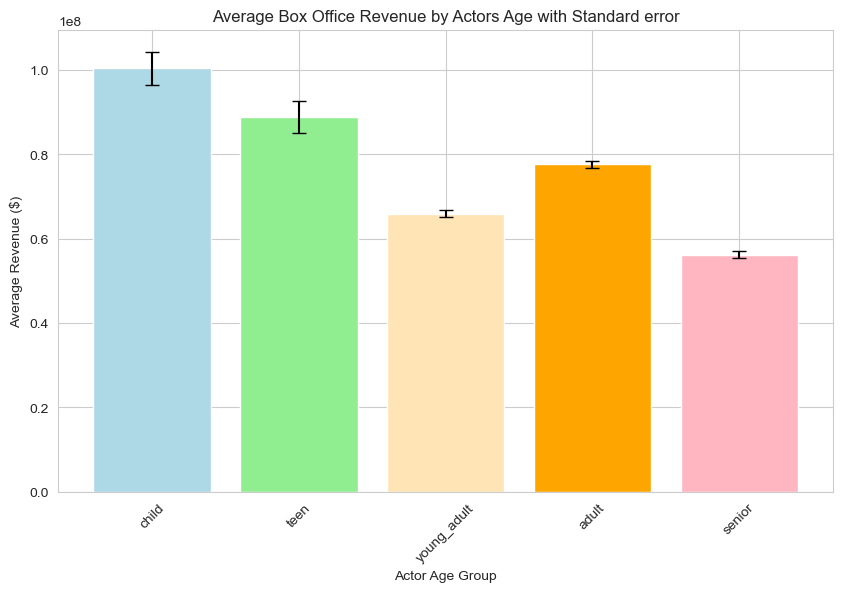

In [17]:
df_actors_revenues['actor_age_group'] = df_actors_revenues['actor_age'].apply(data_utils.categorize_age_group)

age_stats = df_actors_revenues.groupby('actor_age_group')['box_office_revenue'].agg(['mean', 'count', 'sem'])
age_stats = age_stats.loc[['child', 'teen', 'young_adult', 'adult', 'senior']]

print("Average Box Office Revenue by Actors Age:")
print(age_stats)

plt.figure(figsize=(10, 6))
plt.bar(age_stats.index, age_stats['mean'], yerr=age_stats['sem'], color=['lightblue', 'lightgreen', 'moccasin', 'orange', 'lightpink'], capsize=5)
plt.title('Average Box Office Revenue by Actors Age with Standard error')
plt.xlabel('Actor Age Group')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis

The average box office revenues based on the actors age in the films are as follows:
- child            $10M   (1951)
- teen             $8.8M  (2215)
- young_adult      $6.5M  (30169)
- adult            $7.7M  (41313)
- senior           $5.6M  (25205)

##### Observations

1. In average, it seems that films with a young casting performed better. This could be a lead to investigate for producer that seek for a higher box office revenue. Nevertheless, this intuiton is more volatile and could be false in real life whereas the huge quantity of samples for adults make this statistic more robust. 


#### Is there a linear relation between the mean actor's age and the revenue ?

In [22]:
df_mean_actor_age = df_actors_revenues.groupby('wikipedia_movie_id').agg({'actor_age': 'mean', 'box_office_revenue': 'mean'}).reset_index()

mod = smf.ols(formula='box_office_revenue ~ actor_age', data=df_mean_actor_age)

np.random.seed(2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     box_office_revenue   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     75.27
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           4.92e-18
Time:                        23:11:22   Log-Likelihood:            -1.5832e+05
No. Observations:                7927   AIC:                         3.166e+05
Df Residuals:                    7925   BIC:                         3.167e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.459e+06   6.77e+06     -1.102      0.2

#### 5.2 Actors Gender
##### Does the **_gender distribution of actors_** in a film influence its average box office revenue?

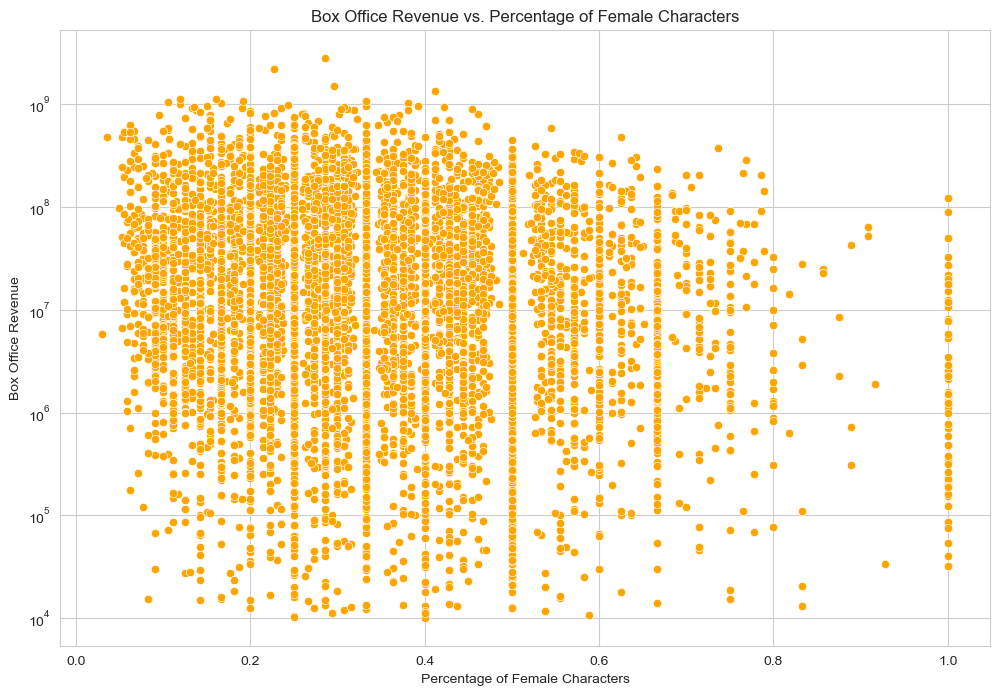

In [18]:
movies_gender_distribution = df_actors_revenues.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_gender'].value_counts(normalize=True).unstack().reset_index()
movies_gender_distribution = movies_gender_distribution.rename(columns={'F': 'Female', 'M': 'Male'})

plt.figure(figsize=(12, 8))
sns.scatterplot(data=movies_gender_distribution, x='Female', y='box_office_revenue', color='orange')
plt.xlabel('Percentage of Female Characters')
plt.ylabel('Box Office Revenue')
plt.yscale('log')
plt.title('Box Office Revenue vs. Percentage of Female Characters')
plt.show()

##### What is the average box office revenue based on the **_gender predominance_** in the movie cast?

Average Box Office Revenue by Actors Gender Dominance:
predominant_gender
Balanced    3.516790e+07
Female      2.898867e+07
Male        5.427904e+07
Name: mean, dtype: float64


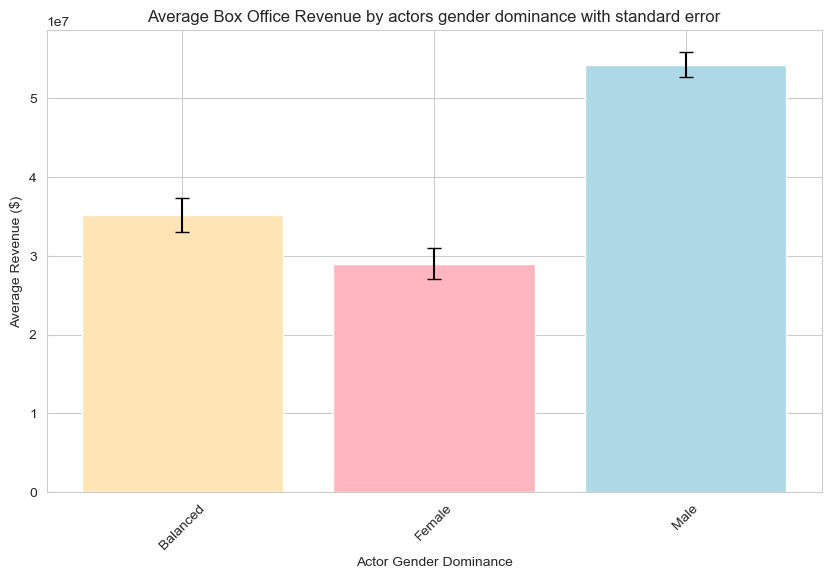

In [19]:
movies_gender_distribution['predominant_gender'] = movies_gender_distribution.apply(
    lambda row: 'Balanced' if abs(row['Male'] - row['Female']) < 0.1 else row[['Male', 'Female']].idxmax(), axis=1
)
gender_stats = movies_gender_distribution.groupby('predominant_gender')['box_office_revenue'].agg(['mean', 'sem'])

print("Average Box Office Revenue by Actors Gender Dominance:")
print(gender_stats['mean'])

plt.figure(figsize=(10, 6))
plt.bar(gender_stats.index, gender_stats['mean'], yerr=gender_stats['sem'], color=['moccasin', 'lightpink', 'lightblue'], capsize=5)
plt.title('Average Box Office Revenue by actors gender dominance with standard error')
plt.xlabel('Actor Gender Dominance')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis

##### Observations

1. This plots suggest that films with male predominance tend to have a higher average box office revenue than those with female predominance or balanced films.

#### 5.3 Actors Ethnicity
##### What is the average box office revenue based on the **_ethnic diversity_** in the movie cast?

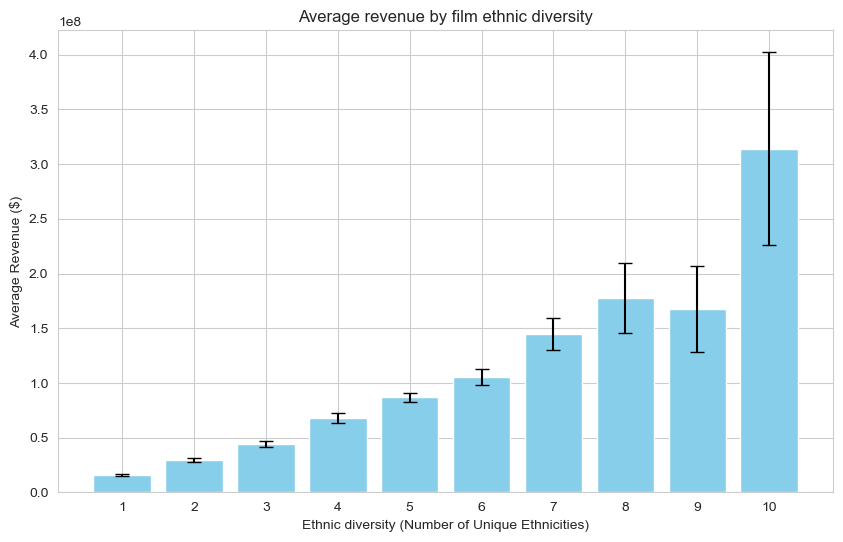

In [20]:
df_exploded = df_actors_revenues.explode('actor_ethnicity')

ethnicity_count = df_exploded.groupby('actor_ethnicity')['actor_name'].nunique().reset_index()
ethnicity_count.columns = ['actor_ethnicity', 'num_actors']

relevant_ethnicities = ethnicity_count[ethnicity_count['num_actors'] > 50]
df_filtered = df_exploded[df_exploded['actor_ethnicity'].isin(relevant_ethnicities['actor_ethnicity'])]

diversity_per_movie = df_filtered.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_ethnicity'].nunique().reset_index()
diversity_per_movie.columns = ['wikipedia_movie_id', 'box_office_revenue', 'diversity']

revenue_per_diversity = diversity_per_movie.groupby('diversity')['box_office_revenue'].agg(['mean', 'sem'])

plt.figure(figsize=(10, 6))
plt.bar(revenue_per_diversity.index, revenue_per_diversity['mean'], yerr=revenue_per_diversity['sem'], color='skyblue', capsize=5)
plt.xticks(revenue_per_diversity.index)
plt.xlabel('Ethnic diversity (Number of Unique Ethnicities)')
plt.ylabel('Average Revenue ($)')
plt.title('Average revenue by film ethnic diversity')
plt.show()

#### Analysis

##### Observations

1. This plots suggests a strong correlation between the diversity of the cast and the revenue.

##### Does the **_ethnicity of the actors_** impact average box office revenue? Which ethnicities have the highest average box office revenue?

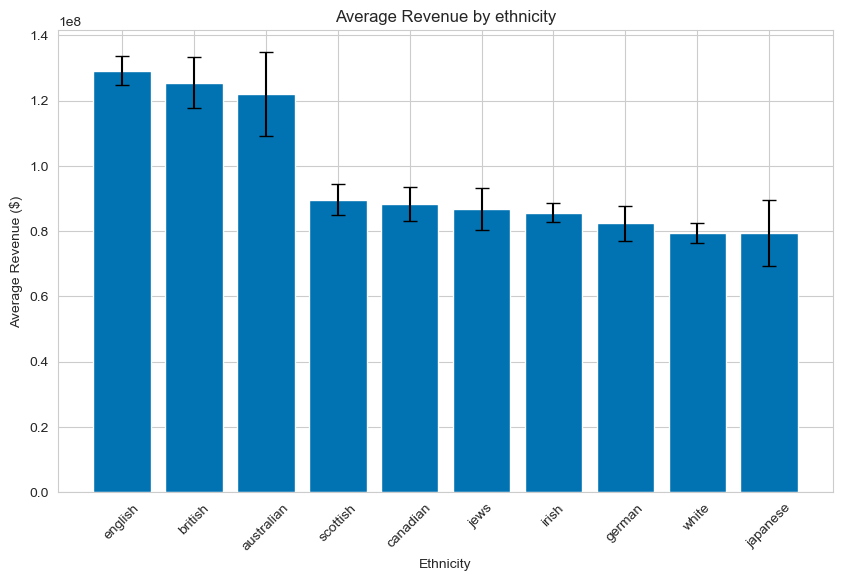

In [21]:
revenue_per_ethnicity = df_filtered.groupby('actor_ethnicity')['box_office_revenue'].agg(['mean', 'sem'])
revenue_per_ethnicity = revenue_per_ethnicity.sort_values(by='mean', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(revenue_per_ethnicity.index, revenue_per_ethnicity['mean'], yerr=revenue_per_ethnicity['sem'], capsize=5)
plt.xlabel('Ethnicity')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by ethnicity')
plt.xticks(rotation=45)
plt.show()

### 6. How have these features have evolved over time ?

We discovered some trends during the EDA analysis but to give an accurate advice to film producers, we need to understand if trends are coming, leaving or have always been there. Therefore, analyse how it has changed overtime will give us a good understanding on that.

#### How did **box office revenue** evolved over time?

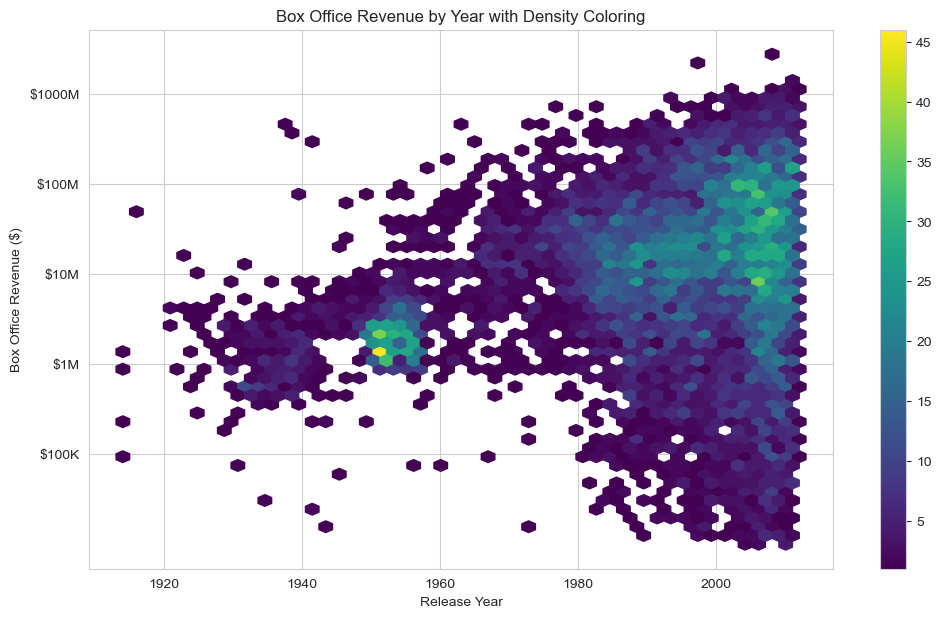

Pearson correlation between release year and box office revenue: PearsonRResult(statistic=0.18553686199305394, pvalue=2.2556583932819033e-65)


In [23]:
plt.figure(figsize=(12, 7))

plt.hexbin(df_movies['release_year'], np.log(df_movies['box_office_revenue']), gridsize=50, cmap='viridis', mincnt=1)

custom_ticks = np.log1p([1e5, 1e6, 1e7, 1e8, 1e9])  
custom_labels = ['$100K', '$1M', '$10M', '$100M', '$1000M'] 

plt.yticks(custom_ticks, custom_labels)
plt.colorbar()
plt.xlabel('Release Year')
plt.ylabel('Box Office Revenue ($)')
plt.title('Box Office Revenue by Year with Density Coloring')
plt.show()

# Calculate pearson correlation
print(f"Pearson correlation between release year and box office revenue: {stats.pearsonr(df_movies['release_year'], df_movies['box_office_revenue'])}")


##### Analysis

It is nice to see that the industry is not dying! At first glance, we see of course more movies and thus the revenue is more diverse. But thanks to the mean and the Pearson correlation coefficient along the the p-value, we can be sure that there is a small (0.18) but significant (p < 0.05) correlation between time and revenue.

Moreover, we can see that the revenue distribution is more and more spread through the decades. This means that it is possible for some movies to perform really well and reinforce the idea that it is interesting to look at the factors that are allowing these results.

#### How did **box office revenue** evolved over time for each **_genre_**?

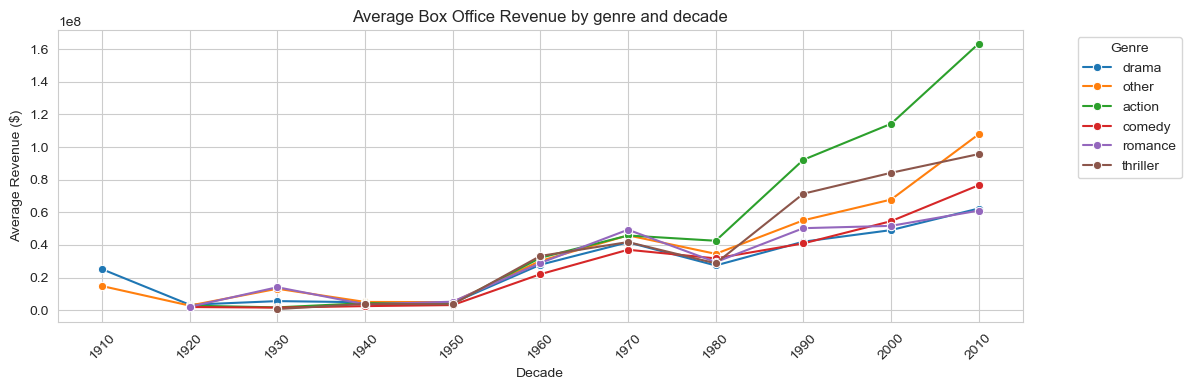

In [24]:
df_movies_genres = df_movies.explode('genres').copy()
df_movies_genres.dropna(subset=['genres'], inplace=True)
df_movies_genres['genre'] = df_movies_genres['genres'].apply(lambda x: x if x in top_genres['genre'].head(5).tolist() else 'other')
df_movies_genres['release_decade'] = df_movies_genres['release_year'] // 10 * 10

genre_decade_stats = df_movies_genres.groupby(['release_decade', 'genre'])['box_office_revenue'].agg(['mean', 'count', 'sem'])
genre_decade_stats.sort_values(by='release_decade', inplace=True)

plt.figure(figsize=(12, 4))
sns.lineplot(data=genre_decade_stats.reset_index(), x='release_decade', y='mean', hue='genre', marker='o', palette='tab10')
plt.title('Average Box Office Revenue by genre and decade')
plt.xlabel('Decade')
plt.ylabel('Average Revenue ($)')
plt.xticks(np.arange(min(genre_decade_stats.index.get_level_values(0)), max(genre_decade_stats.index.get_level_values(0))+1, 10), rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Analysis

We can see that there are indeed times where one genre perfomed better than the others, and also that in the lastest decades, the action genre is taking the spotlight.

#### How has **_runtime_** changed along the years and how it correlates with revenue?

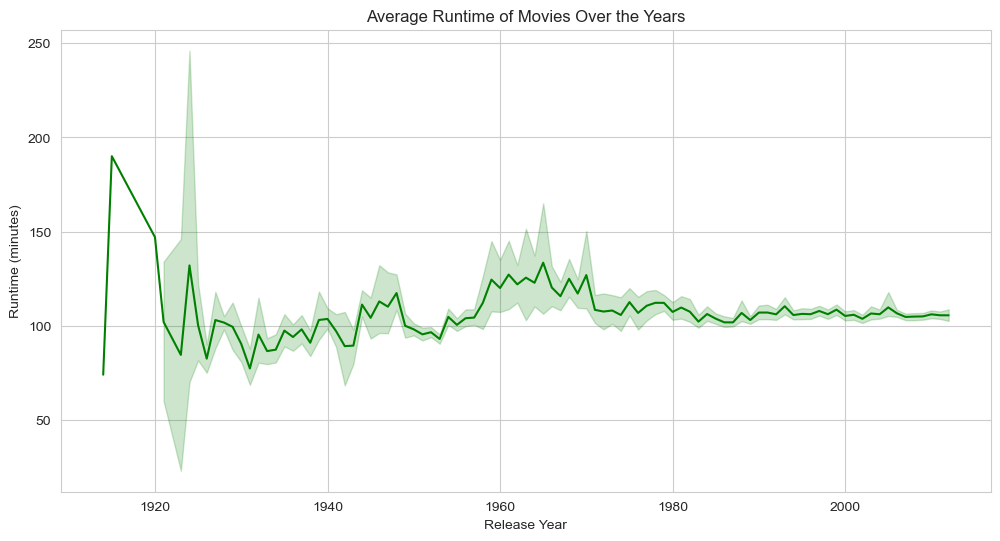

In [25]:
# plot the average runtime through the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_movies, x='release_year', y='runtime', color='green')
plt.title('Average Runtime of Movies Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Runtime (minutes)')
plt.show()


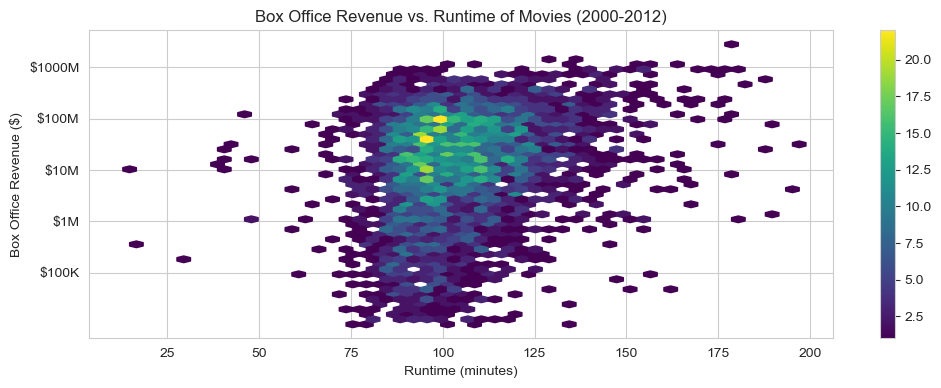

Pearson correlation between runtime and box office revenue: PearsonRResult(statistic=0.25140857584572335, pvalue=1.9147429226310332e-53)


In [26]:
# focus on the new millenium and scatter plot runtime vs revenue
df_movies_after_2000 = df_movies[df_movies['release_year'] >= 2000]
df_movies_after_2000 = df_movies_after_2000[df_movies_after_2000['runtime'] <= 200]

plt.figure(figsize=(12, 4))
plt.hexbin(df_movies_after_2000['runtime'], np.log(df_movies_after_2000['box_office_revenue']),gridsize=50, cmap='viridis', mincnt=1)
plt.title('Box Office Revenue vs. Runtime of Movies (2000-2012)')
plt.colorbar()
custom_ticks = np.log1p([1e5, 1e6, 1e7, 1e8, 1e9])  
custom_labels = ['$100K', '$1M', '$10M', '$100M', '$1000M']  
plt.yticks(custom_ticks, custom_labels)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Box Office Revenue ($)')
plt.show()

# calculate the pearson correlation
print(f"Pearson correlation between runtime and box office revenue: {stats.pearsonr(df_movies_after_2000['runtime'], df_movies_after_2000['box_office_revenue'])}")


##### Analysis

The average runtime has fluctuated a lot but seems to stabilize since the 90s. Moreover, we can see that the confidence interval narrows as weel which indicate than movie's runtime tend to uniformize. It settles around 105 minutes.

The second plot focuses on the past 2 decades for a more fine-grained analysis. It aims to understand the trend of the 2000's. As we can see both in the graph and with the pearson correlation coefficient, it seems that we have a small but significant positive correlation between runtime and revenue.

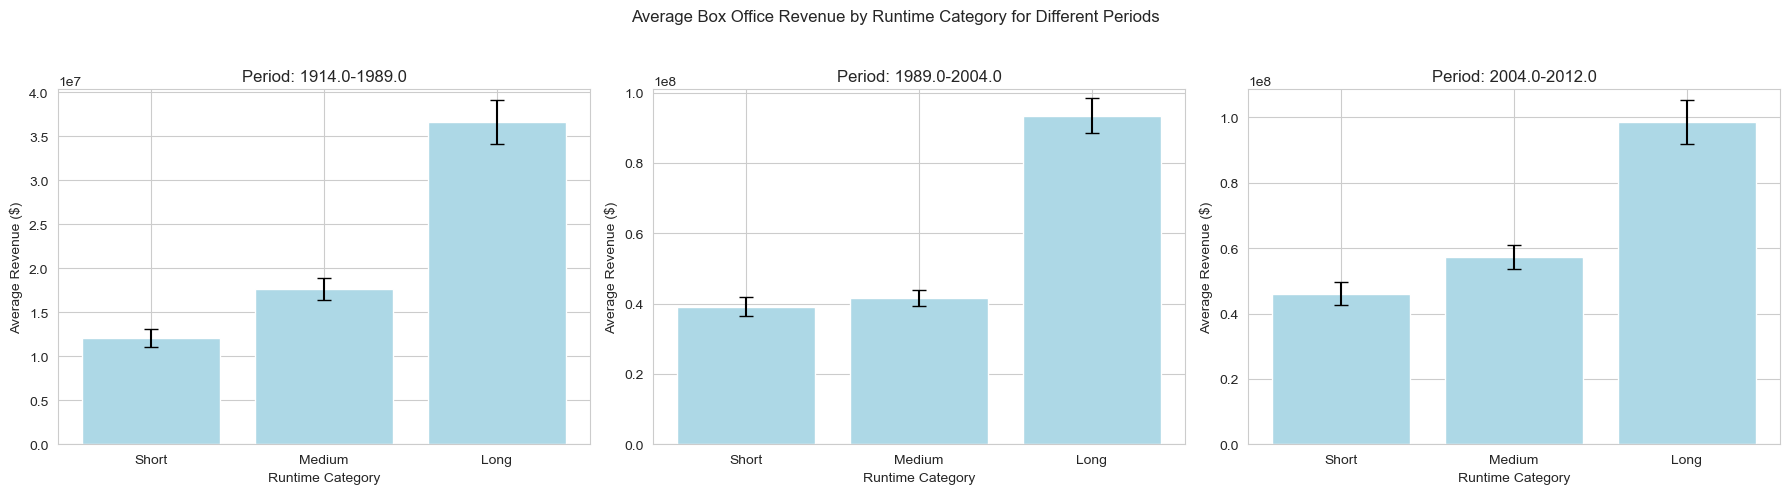

In [27]:
# Sort and divide movies in 3 different periods containing the same number of movies
df_movies_sorted = df_movies.sort_values('release_year').reset_index(drop=True)
total_movies = len(df_movies_sorted)
group_size = total_movies // 3
boundaries = [0, group_size, 2 * group_size, total_movies]
time_periods = [
    (df_movies_sorted.loc[boundaries[i], 'release_year'], 
     df_movies_sorted.loc[boundaries[i + 1] - 1, 'release_year']) 
    for i in range(3)
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Average Box Office Revenue by Runtime Category for Different Periods')

for i, (start_year, end_year) in enumerate(time_periods):
    period_movies = df_movies[(df_movies['release_year'] >= start_year) & (df_movies['release_year'] <= end_year)].copy()

    period_movies['runtime_category'] = pd.qcut(period_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])
    runtime_stats = period_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])

    axes[i].bar(runtime_stats.index, runtime_stats['mean'], yerr=runtime_stats['sem'], color='lightblue', capsize=5)
    axes[i].set_title(f'Period: {start_year}-{end_year}')
    axes[i].set_xlabel('Runtime Category')
    axes[i].set_ylabel('Average Revenue ($)')
    axes[i].set_ylim(0, runtime_stats['mean'].max() + runtime_stats['sem'].max() * 1.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### Analysis

It can be seen that since 1914 (first movie by release data of our dataset) long movies performed better for revenues. It can also be noticed that the plots of the period 1914-1989 and the period 2004-2012 have almost identical trend, the standard errors and the difference between the three runtime categories has the same height. It can be concluded that long movies generated higher revenues, while short and medium movies generated slightly more than half revenues respect to the long movies. 

### 7. Sentimental Analysis

#### Are there specific schemes regarding the sentiment(s) presen in the summary of success movies ?

Box Office Groups: ['Very High', 'Low', 'Medium', 'High']
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Very High']


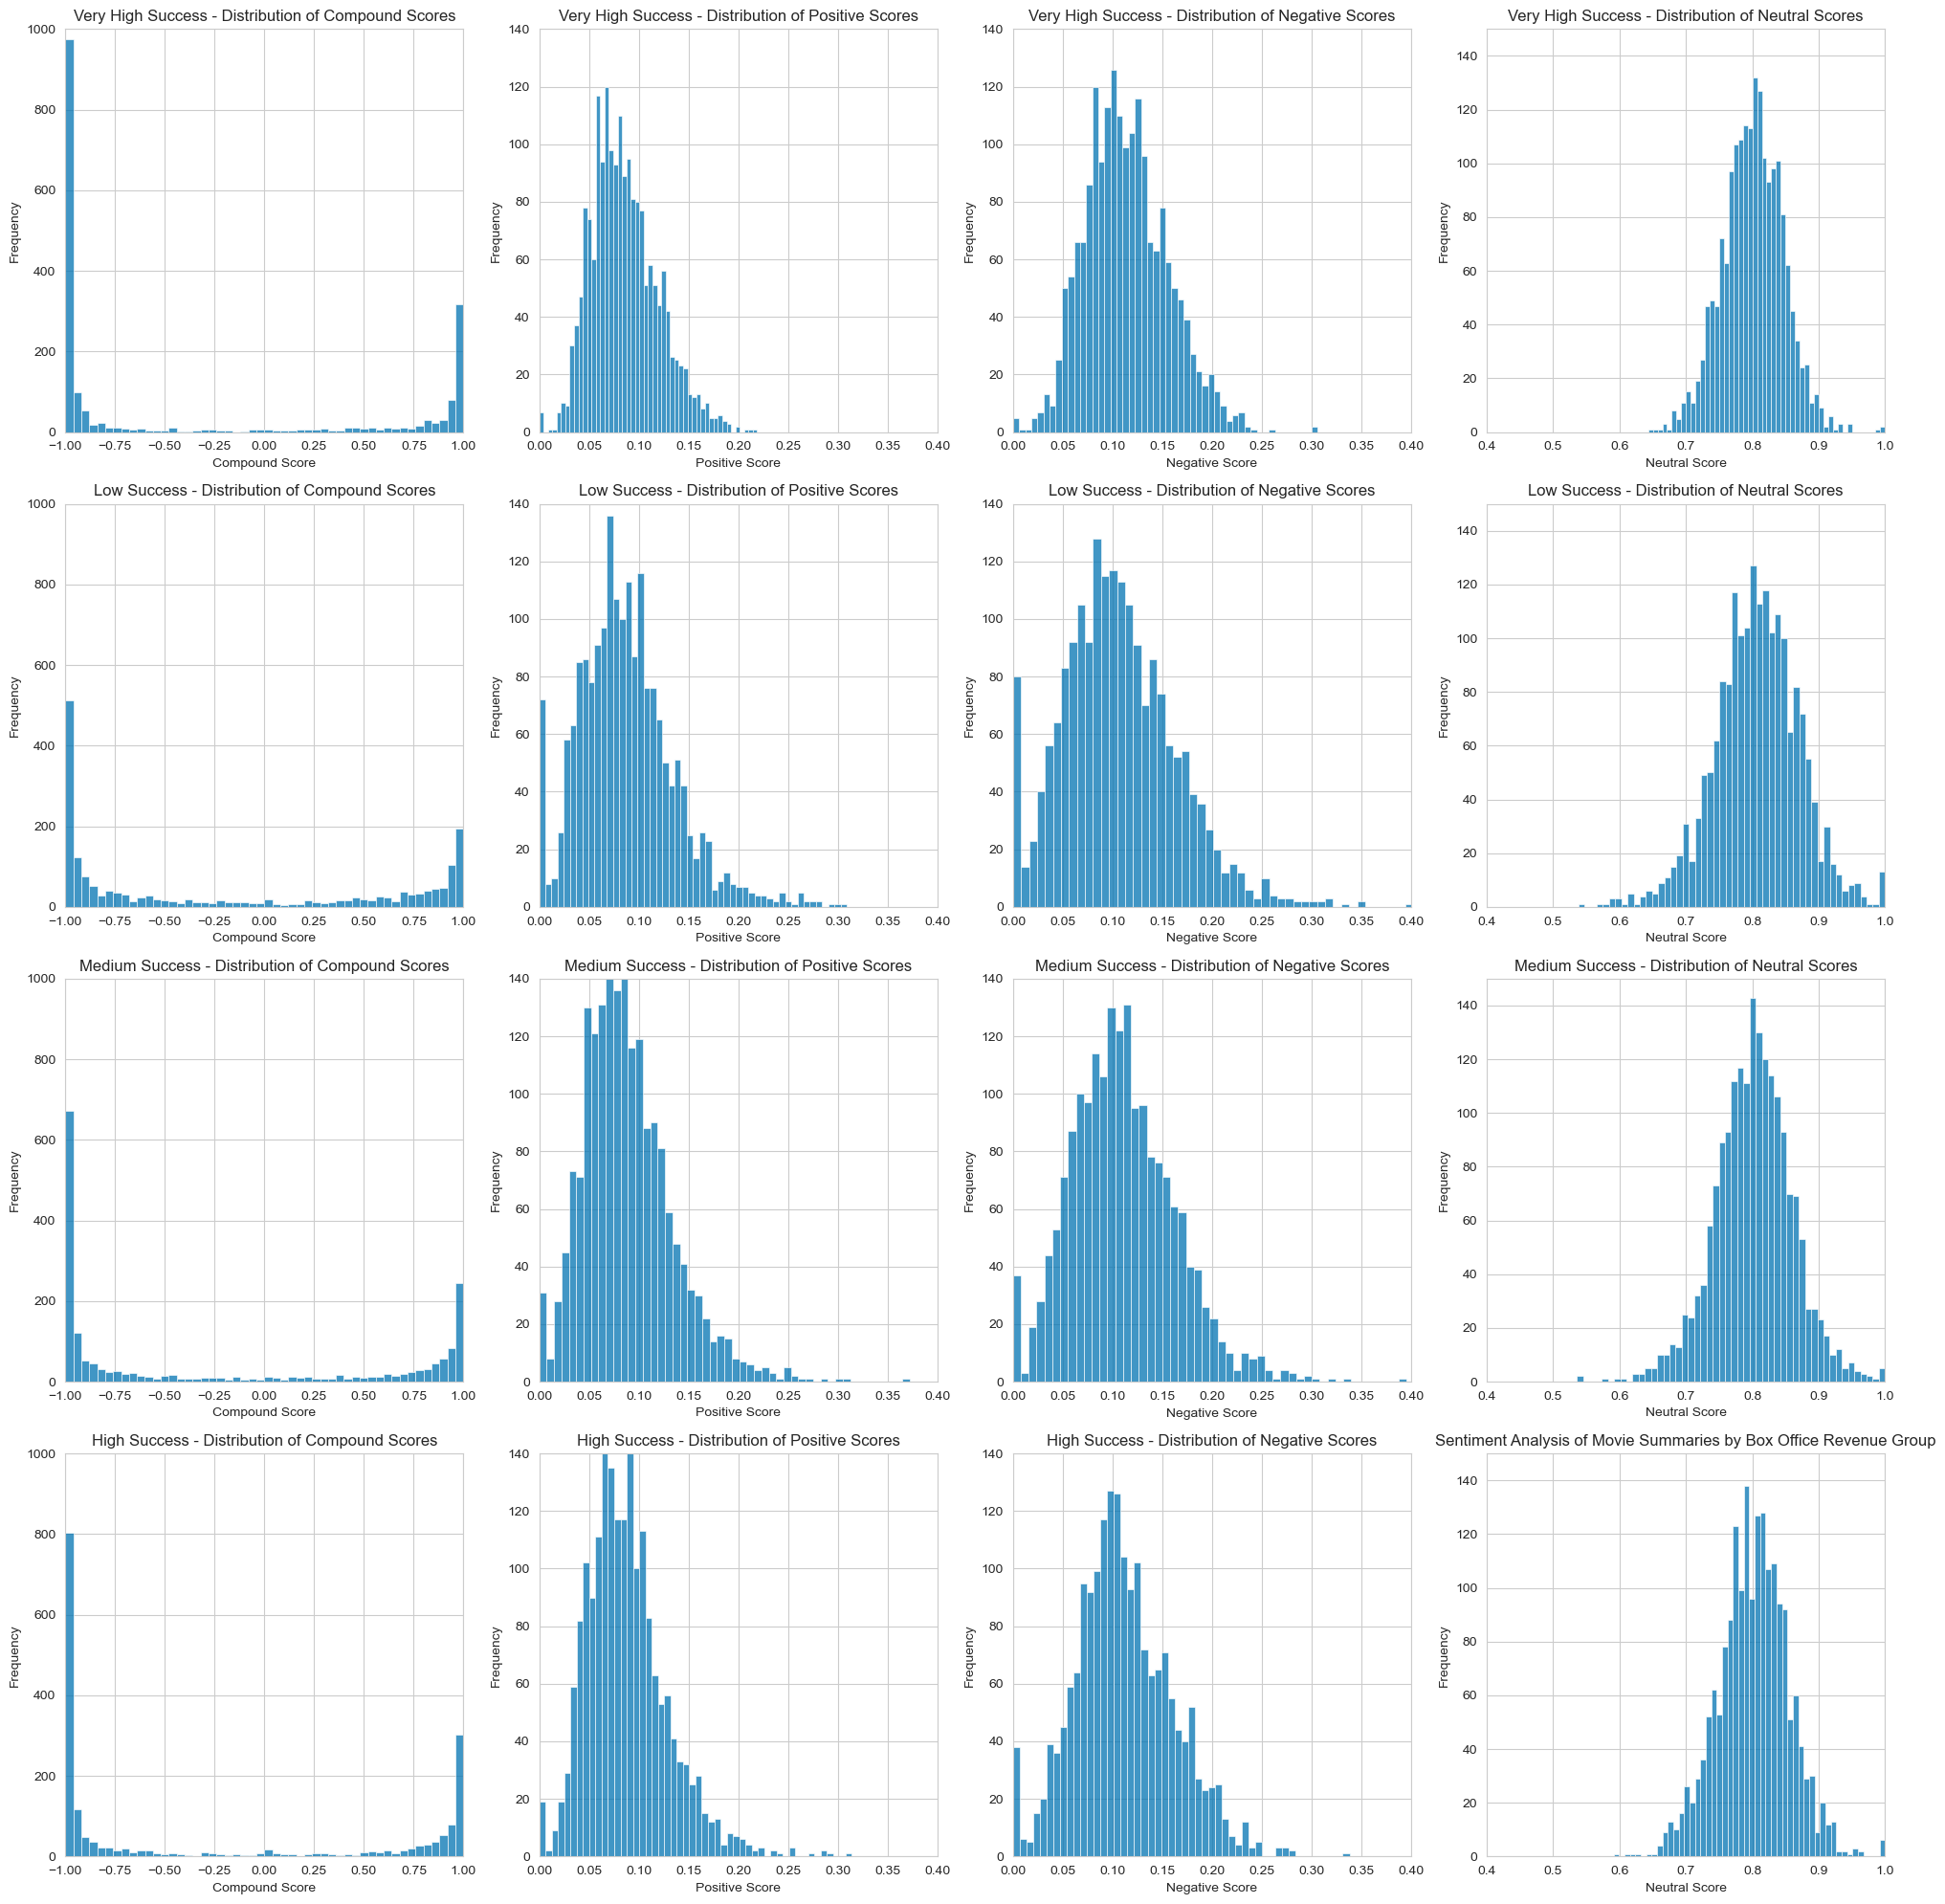

In [ ]:
movie_summaries_df = df_plots.merge(df_movies, left_on='movie_id', right_on='wikipedia_movie_id', how='inner')
movie_summaries_df = movie_summaries_df.drop(columns=['wikipedia_movie_id', 'release_date', 'runtime', 'languages', 'countries', 'genres'])
movie_summaries_df['box_office_group'] = pd.qcut(movie_summaries_df['box_office_revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

analyzer = SentimentIntensityAnalyzer()
movie_summaries_df['vader_scores'] = movie_summaries_df['summary'].apply(lambda x: analyzer.polarity_scores(x))

# Plotting distributions for each box office group
movie_summaries_df = movie_summaries_df.dropna(subset=['box_office_group'])
box_office_groups = movie_summaries_df['box_office_group'].unique()

fig, axs = plt.subplots(len(box_office_groups), 4, figsize=(20, 20))

for i, group in enumerate(box_office_groups):
    group_data = movie_summaries_df[movie_summaries_df['box_office_group'] == group]
    
    sns.histplot(group_data['vader_scores'].apply(lambda x: x['compound']), bins=50, ax=axs[i, 0])
    axs[i, 0].set_title(f'{group} Success - Distribution of Compound Scores')
    axs[i, 0].set_xlabel('Compound Score')
    axs[i, 0].set_ylabel('Frequency')

    sns.histplot(group_data['vader_scores'].apply(lambda x: x['pos']), bins=50, ax=axs[i, 1])
    axs[i, 1].set_title(f'{group} Success - Distribution of Positive Scores')
    axs[i, 1].set_xlabel('Positive Score')
    axs[i, 1].set_ylabel('Frequency')

    sns.histplot(group_data['vader_scores'].apply(lambda x: x['neg']), bins=50, ax=axs[i, 2])
    axs[i, 2].set_title(f'{group} Success - Distribution of Negative Scores')
    axs[i, 2].set_xlabel('Negative Score')
    axs[i, 2].set_ylabel('Frequency')

    sns.histplot(group_data['vader_scores'].apply(lambda x: x['neu']), bins=50, ax=axs[i, 3])
    axs[i, 3].set_title(f'{group} Success - Distribution of Neutral Scores')
    axs[i, 3].set_xlabel('Neutral Score')
    axs[i, 3].set_ylabel('Frequency')

    axs[i, 0].set_xlim(-1, 1)
    axs[i, 1].set_xlim(0, 0.4)
    axs[i, 2].set_xlim(0, 0.4)
    axs[i, 3].set_xlim(0.4, 1)
    axs[i, 0].set_ylim(0, 1000)
    axs[i, 1].set_ylim(0, 140)
    axs[i, 2].set_ylim(0, 140)
    axs[i, 3].set_ylim(0, 150)

plt.title('Sentiment Analysis of Movie Summaries by Box Office Revenue Group')
plt.tight_layout()

##### Analysis

We can see by the plots above that a simple sentimal analysis done like this does not provide very strong results. Nevertheless, we can say from theses plots that high sucess movies tends to be all pretty close to the following values (negative=0.10, positive=0.77, neutral=0.81). We see that groups with less box office revenue tends to be more spread around those values indacting that these groups are probably less diverse.

#### Is the dominant balance of feelings of a plot summary influence its success ?

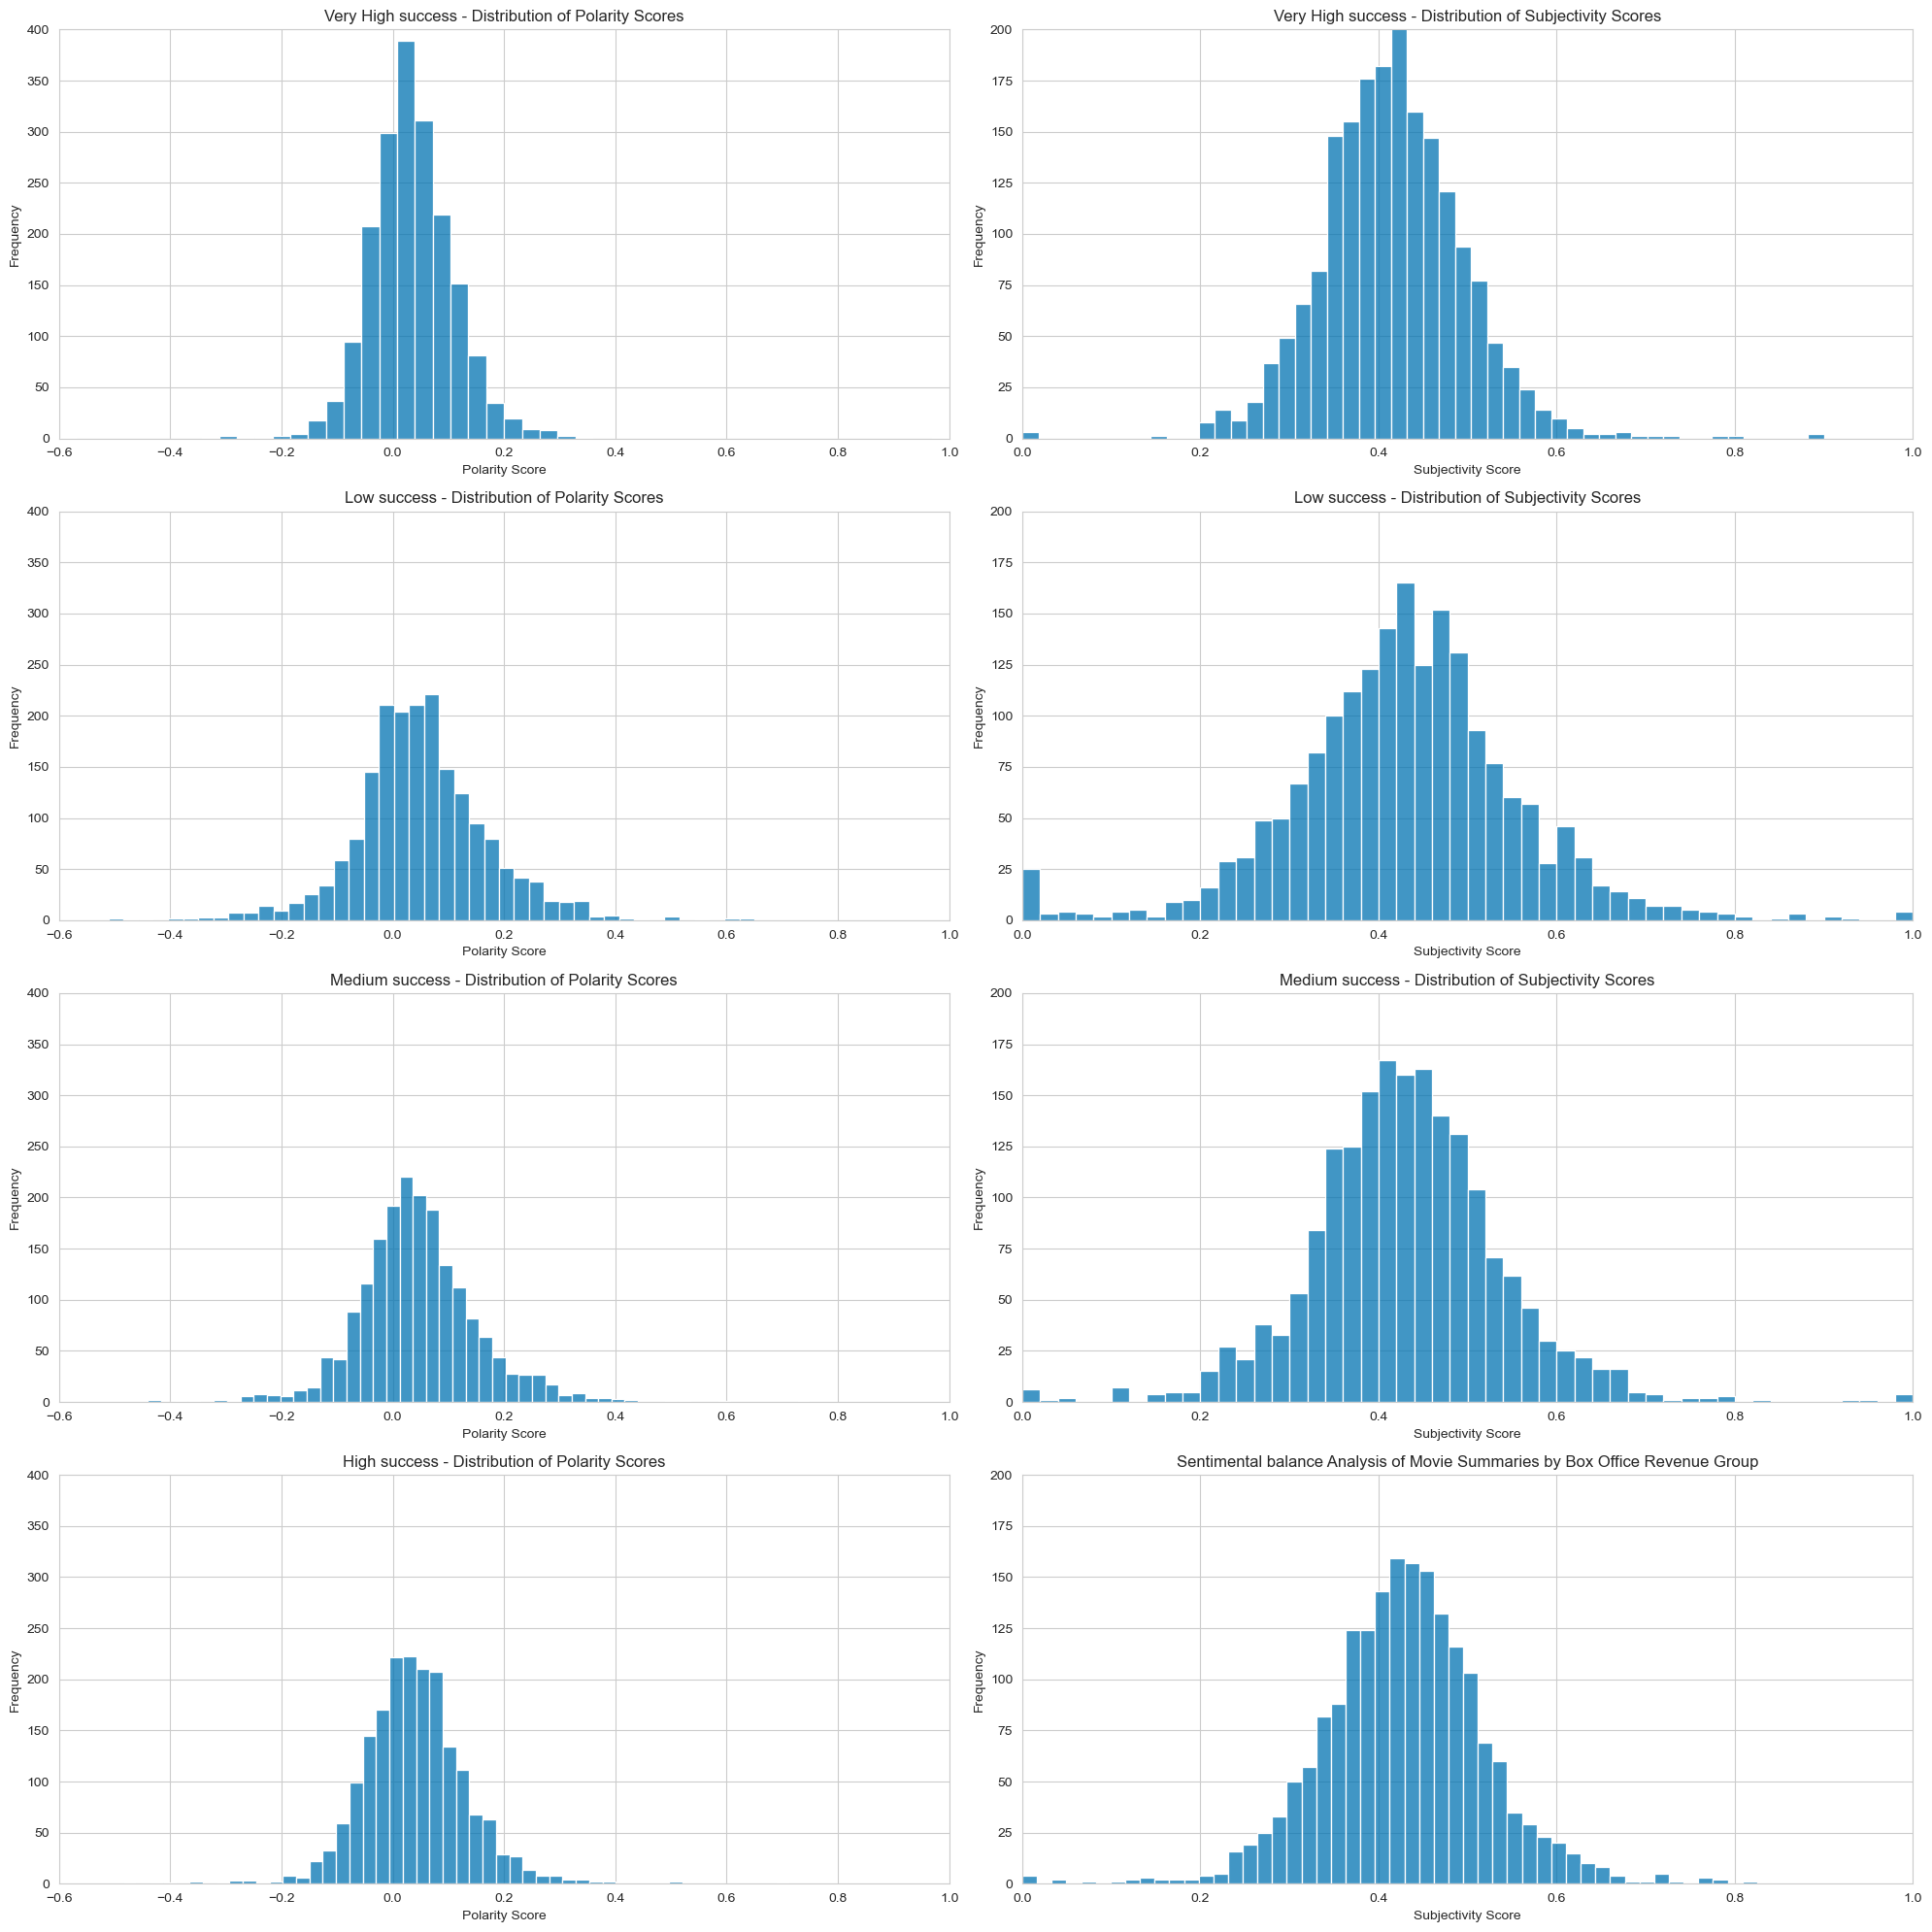

In [46]:
movie_summaries_df['textblob_sentiment'] = movie_summaries_df['summary'].apply(data_utils.get_textblob_sentiment)

# Plotting distributions for each box office group
box_office_groups = movie_summaries_df['box_office_group'].unique()

fig, axs = plt.subplots(len(box_office_groups), 2, figsize=(20, 20))

for i, group in enumerate(box_office_groups):
    group_data = movie_summaries_df[movie_summaries_df['box_office_group'] == group]
    
    sns.histplot(group_data['textblob_sentiment'].apply(lambda x: x[0]), bins=50, ax=axs[i, 0])
    axs[i, 0].set_title(f'{group} success - Distribution of Polarity Scores')
    axs[i, 0].set_xlabel('Polarity Score')
    axs[i, 0].set_ylabel('Frequency')

    sns.histplot(group_data['textblob_sentiment'].apply(lambda x: x[1]), bins=50, ax=axs[i, 1])
    axs[i, 1].set_title(f'{group} success - Distribution of Subjectivity Scores')
    axs[i, 1].set_xlabel('Subjectivity Score')
    axs[i, 1].set_ylabel('Frequency')

    axs[i, 0].set_xlim(-0.6, 1)
    axs[i, 1].set_xlim(0, 1)
    axs[i, 0].set_ylim(0, 400)
    axs[i, 1].set_ylim(0, 200)

plt.title('Sentimental balance Analysis of Movie Summaries by Box Office Revenue Group')
plt.tight_layout()
plt.show()

##### Analysis

Here again, the lack of diversity in the results makes it harder to retrieve interesting informations from it. We can say once again that groups with higher revenue tends to be better grouped (polarity=0.05, subjectivity=0.45). It is interesting to note that the polarity must be the closest possible from 0.

To conclude this light analysis on summary's sentiment, we could say that it does not seems to be relevant when regarding how it affects the box office revenue. Of course, we could argue that more data, better processing and sentimental analysis could result in better results and this is absolutly true.
Based on the results, we can still note that the movie's summary doesn't seems to highly influence the box office revenue. This is interesting as the goal of the analysis is to find what does or **does not** impact a movie's success.

## Part 3: Create a Predictive Model for Box Office Success

In this part, our goal is to build a predictive model that classifies whether a movie will be a "success" or a "failure" at the box office. 

### Overview
1. **Regression Models**: We initially aimed to predict the exact revenue of a movie using regression models such as Random Forest and Gradient Boosting. However, the results were unsatisfactory due to the complexity and variability of the features, along with the lack of budget data for many movies.
   
2. **Classification Models**: To simplify the prediction task and provide actionable insights, we shifted to a classification-based approach. Here, a movie is classified as "successful" (1) or "unsuccessful" (0) based on its performance against a defined threshold.

### Data Sources

The primary datasets include:

1. **CMU Movie Dataset**:
   - **Movie Metadata**: Provides details like runtime, release year, genres etc...
   - **Character Metadata**: Includes information about actors.
   - **Plot Summaries**: Contains summaries of movie plots.

2. **Kaggle Movie Financial Dataset**:
   - This dataset includes financial details such as movie budgets, lifetime gross, ratings, and runtimes. We used this data to integrate movie budget information into our analysis.
   - **Source**: [Global Movie Franchise Revenue and Budget Data](https://www.kaggle.com/datasets/thedevastator/global-movie-franchise-revenue-and-budget-data?resource=download).
   - Note: Fuzzy matching was employed to merge movies across datasets due to differences in title formatting and other inconsistencies.

In [28]:
df_movies = pd.read_csv('data/preprocessed/movie.metadata.csv')
df_characters = pd.read_csv('data/preprocessed/character.metadata.csv')

### Data Preparation: Merging Features

In this step, we prepare the data for modeling by combining multiple features from the available dataset:

1. **Character Data Aggregation**:
   - We aggregate character data grouped by `wikipedia_movie_id` to calculate:
     - The total number of actors (`num_actors`).
     - The number of male actors (`num_male_actors`) and female actors (`num_female_actors`).
     - The average age of the actors (`avg_actor_age`), excluding rows where all ages are marked as 'Unknown'.
     - The diversity of ethnicities (`ethnicity_list`) as a list for each movie.

2. **Merging Character Data with Movie Metadata**:
   - The character data is merged with the movie metadata using `wikipedia_movie_id` as the key.
   - A new feature `is_holiday_release` is added to indicate whether a movie was released during peak holiday months (June, July, August, December).

3. **Removing Rows with Missing Values**:
   - Rows with NaN values in critical features are removed to ensure clean data for modeling.

In [29]:
character_summary = df_characters.groupby('wikipedia_movie_id').agg(
    num_actors=('actor_name', 'nunique'),
    num_male_actors=('actor_name', lambda x: x[df_characters.loc[x.index, 'actor_gender'] == 'M'].nunique()),
    num_female_actors=('actor_name', lambda x: x[df_characters.loc[x.index, 'actor_gender'] == 'F'].nunique()),
    avg_actor_age=('actor_name', lambda x: pd.to_numeric(df_characters.loc[x.index, 'actor_age'], errors='coerce').drop_duplicates().mean() if not df_characters.loc[x.index, 'actor_age'].eq('Unknown').all() else np.nan),
    ethnicity_list=('actor_name', lambda x: list(set(df_characters.loc[x.index, 'actor_ethnicity'].dropna())))
).reset_index()

df_combined = df_movies.merge(character_summary, on='wikipedia_movie_id', how='left')
df_combined['is_holiday_release'] = df_combined['release_month'].isin([6, 7, 8, 12]).astype(int)

df_combined.dropna(subset=['runtime', 'release_year', 'is_holiday_release', 'num_actors', 'num_male_actors', 'num_female_actors', 'avg_actor_age'], inplace=True)
df_combined.head(20)

,wikipedia_movie_id,movie_name,box_office_revenue,runtime,languages,countries,genres,release_day,release_month,release_year,num_actors,num_male_actors,num_female_actors,avg_actor_age,ethnicity_list,is_holiday_release
0,975900,Ghosts of Mars,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['adventure', 'supernatural', 'science-fiction...",24.0,8.0,2001.0,17.0,11.0,6.0,43.583333,"[['african', 'american'], ['omaha', 'tribe', '...",1
1,10408933,Alexander's Ragtime Band,3600000.0,106.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['musical', 'black-and-white', 'comedy']",16.0,8.0,1938.0,4.0,2.0,2.0,25.666667,"[['french', 'american'], ['irish', 'american']]",1
2,171005,Henry V,10161099.0,137.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"['adaptation', 'costume', 'period_piece', 'dra...",8.0,11.0,1989.0,21.0,17.0,3.0,45.263158,"[['scottish'], ['english'], ['british']]",0
3,77856,Mary Poppins,102272727.0,139.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},[],27.0,8.0,1964.0,12.0,6.0,6.0,41.250000,"[['dutch', 'american'], ['english']]",1
4,612710,New Rose Hotel,21521.0,92.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['adaptation', 'noir', 'science-fiction', 'ero...",1.0,10.0,1999.0,8.0,4.0,3.0,40.285714,"[['italian'], ['german', 'american']]",0
5,156558,Baby Boy,29381649.0,123.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['drama', 'fiction', 'coming_of_age', 'crime']",27.0,6.0,2001.0,37.0,11.0,12.0,34.583333,"[['african', 'american']]",1
6,1364293,They Knew What They Wanted,932000.0,96.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['black-and-white', 'drama', 'romance', 'marri...",NaN,NaN,1940.0,5.0,4.0,1.0,30.666667,"[['serbian', 'american']]",0
7,261237,The Gods Must Be Crazy,34331783.0,109.0,"{'/m/0x82': 'Afrikaans Language', '/m/02h40lc'...",{'/m/0hzlz': 'South Africa'},"['adventure', 'cult', 'slapstick', 'indie', 'a...",NaN,NaN,1980.0,13.0,6.0,1.0,42.833333,[],0
8,12008535,Rudo y Cursi,11091868.0,103.0,{'/m/06nm1': 'Spanish Language'},"{'/m/0b90_r': 'Mexico', '/m/09c7w0': 'United S...","['drama', 'comedy', 'sports', 'family']",NaN,NaN,2008.0,9.0,5.0,3.0,37.500000,"[['mexican'], ['criollo']]",0
9,4951456,Kinjite: Forbidden Subjects,3416846.0,97.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['adventure', 'fiction', 'action', 'thriller',...",NaN,NaN,1989.0,9.0,6.0,3.0,43.666667,"[['african', 'american'], ['irish', 'american'...",0


### Regression Modeling: Predicting Box Office Revenue

We test regression models to predict the box office revenue of movies using the selected features:

1. **Feature Selection**:
   - The features used for prediction include:
     - `runtime`: The length of the movie in minutes.
     - `release_year`: The year of the movie's release.
     - `is_holiday_release`: Indicates if the movie was released during peak holiday months.
     - `num_actors`: Total number of actors in the movie.
     - `num_male_actors`: Number of male actors in the movie.
     - `num_female_actors`: Number of female actors in the movie.
     - `avg_actor_age`: Average age of actors in the movie.

2. **Target Variable**:
   - `box_office_revenue`: The revenue earned by the movie.

3. **Data Splitting**:
   - The data is split into training and testing sets using an 80-20 split ratio to evaluate model performance.

4. **Feature Standardization**:
   - Features are standardized using `StandardScaler`.

5. **Model Training and Evaluation**:
   - We initialize and train two regression models:
     - **Random Forest Regressor**: A tree-based learning method that averages multiple decision trees.
     - **Gradient Boosting Regressor**: An iterative ensemble method.
   - The models are evaluated on the test set using the following metrics:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.models.random_forest_regression import RandomForestModel
from src.models.gradient_boosting_regressor import GradientBoostingRegressorModel

features = ['runtime', 'release_year', 'is_holiday_release', 'num_actors', 'num_male_actors', 
            'num_female_actors', 'avg_actor_age']
target = 'box_office_revenue'

X = df_combined[features]
y = df_combined[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestModel()
gb_model = GradientBoostingRegressorModel()

rf_model.train(X_train_scaled, y_train)
rf_results = rf_model.evaluate(X_test_scaled, y_test)

gb_model.train(X_train_scaled, y_train)
gb_results = gb_model.evaluate(X_test_scaled, y_test)

Mean Absolute Error (MAE): 50180626.05
Mean Squared Error (MSE): 9268044604610510.00
Root Mean Squared Error (RMSE): 96270684.04
Mean Absolute Error (MAE): 46422893.38
Mean Squared Error (MSE): 8338568346655516.00
Root Mean Squared Error (RMSE): 91315761.76


In [31]:
print("Random Forest Results:", rf_results)
print("Gradient Boosting Results:", gb_results)

Random Forest Results: {'MAE': 50180626.0498028, 'MSE': 9268044604610510.0, 'RMSE': 96270684.035227}
Gradient Boosting Results: {'MAE': 46422893.37664997, 'MSE': 8338568346655516.0, 'RMSE': 91315761.76463467}


### Analysis of Regression Model Performance

The results from the regression models indicate that predicting the exact box office revenue is a highly challenging task, as reflected in the following metrics:

1. **Random Forest Results**:
   - **Mean Absolute Error (MAE)**: ~50.18 million USD
   - **Root Mean Squared Error (RMSE)**: ~96.27 million USD

2. **Gradient Boosting Results**:
   - **Mean Absolute Error (MAE)**: ~46.42 million USD
   - **Root Mean Squared Error (RMSE)**: ~91.32 million USD

Both models show high error values, indicating that predicting the exact box office revenue with the available features is highly uncertain. Factors such as production quality, marketing efforts, and audience reception, which are not present in the dataset, significantly influence revenue.

### Decision to Shift to Classification Models

Given the high errors in regression, we aim to simplify the problem by shifting to **classification models**. Instead of predicting exact revenue values, we classify movies into two categories:

- **High Revenue**: Movies that perform significantly better than a defined threshold.
- **Low Revenue**: Movies that do not exceed the threshold.

This classification approach allows us to focus on distinguishing successful movies from less successful ones, which is more actionable and feasible given the data at hand. The next steps will involve defining thresholds for classification and testing models such as logistic regression and support vector machines (SVM).

In [32]:
mean_revenue = df_combined['box_office_revenue'].mean()
high_revenue_threshold = mean_revenue * 1.2  # 20% above the mean

df_combined['revenue_category'] = df_combined['box_office_revenue'].apply(
    lambda x: 1 if x > high_revenue_threshold else 0
)

X = df_combined[['runtime', 'release_year', 'is_holiday_release', 'num_actors', 'num_male_actors', 'num_female_actors', 'avg_actor_age']]
y = df_combined['revenue_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"High Revenue threshold: {high_revenue_threshold}")
print(f"Class distribution in target variable:\n{y.value_counts(normalize=True)}")

High Revenue threshold: 60373551.3712395
Class distribution in target variable:
0    0.796768
1    0.203232
Name: revenue_category, dtype: float64


### Logistic Regression: Training and Evaluation

To begin our classification analysis, we tested the **Logistic Regression** model.

Using our preprocessed data, we trained the model on the **High Revenue vs. Low Revenue** classification task.

In [33]:
from src.models.logistic_regression import PredLogisticRegression

sklearn_log_reg = PredLogisticRegression(max_iter=1000)

print("Sklearn Logistic Regression:")
sklearn_log_reg.train(X_train, y_train)
sklearn_results = sklearn_log_reg.evaluate(y_test, X_test)

Sklearn Logistic Regression:
Evaluation Metrics:
  Accuracy: 0.82
  Precision: 0.79
  Recall: 0.82
  F1 Score: 0.79


In [34]:
print(f"Logistic Regression Results: {sklearn_results}")

Logistic Regression Results: {'Accuracy': 0.8225190839694656, 'Precision': 0.7914943836089863, 'Recall': 0.8225190839694656, 'F1 Score': 0.786052449365992}


In [35]:
from src.models.svm_model import SVMModel

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTesting SVM Model:")

svm_model = SVMModel(kernel='rbf', C=1.0, gamma='scale')
svm_model.train(X_train_scaled, y_train)
svm_results = svm_model.evaluate(y_test, X_test_scaled)


Testing SVM Model:
Evaluation Metrics:
  Accuracy: 0.83
  Precision: 0.81
  Recall: 0.83
  F1 Score: 0.80

Confusion Matrix:
[[1246   29]
 [ 233   64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1275
           1       0.69      0.22      0.33       297

    accuracy                           0.83      1572
   macro avg       0.77      0.60      0.62      1572
weighted avg       0.81      0.83      0.80      1572



In [36]:
print(f"SVM Model Results: {svm_results}")

SVM Model Results: {'Accuracy': 0.8333333333333334, 'Precision': 0.8133110863922878, 'Recall': 0.8333333333333334, 'F1 Score': 0.7959164292497627}


### Reassessing the Threshold for Revenue Classification

The initial classification threshold—defining a high-revenue movie as one with revenue 20% above the mean—has limitations. It doesn't account for the varying production budgets of movies, which is critical for evaluating box office success. A movie with high revenue but an enormous budget may not be a "success," while a low-budget film with modest revenue could be considered a hit.

To address this, we integrated **budget data** from a Kaggle dataset: [Movie Franchises Dataset on Kaggle](https://www.kaggle.com/datasets/sashritha/movies-franchise-dataset). Using fuzzy matching, we aligned the movie titles between datasets, ensuring accuracy despite variations in formatting.

#### Updated Classification Logic:
1. **Movies with Available Budget**:
   - Classified as high revenue if their revenue is at least **50% above their budget**.
2. **Movies Without Budget Information**:
   - Retain the previous threshold, where revenue 20% above the mean classifies the movie as high revenue.

By incorporating budgets into our classification, we aim to create a more realistic evaluation of movie success.

In [37]:
kaggle_data = pd.read_csv("data/new_data/MovieFranchises.csv")

display(kaggle_data.head())

print(kaggle_data.info())

,index,MovieID,Title,Lifetime Gross,Year,Studio,Rating,Runtime,Budget,ReleaseDate,VoteAvg,VoteCount,FranchiseID
0,0,1001,Star Wars: Episode IV - A New Hope,775398007,1977,Lucasfilm,PG,121.0,11000000.0,05-25-77,4.09,96233.0,101.0
1,1,1002,Star Wars: Episode V - The Empire Strikes Back,538375067,1980,Lucasfilm,PG,124.0,18000000.0,06-20-80,4.12,79231.0,101.0
2,2,1003,Star Wars: Episode VI - Return of the Jedi,475106177,1983,Lucasfilm,PG,135.0,32500000.0,05-25-83,3.98,76082.0,101.0
3,3,1004,Jurassic Park,1109802321,1993,Universal Pictures,PG-13,127.0,63000000.0,06-11-93,3.69,82700.0,102.0
4,4,1005,The Lost World: Jurassic Park,618638999,1997,Universal Pictures,PG-13,129.0,73000000.0,05-23-97,3.01,19721.0,102.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           605 non-null    int64  
 1   MovieID         605 non-null    object 
 2   Title           605 non-null    object 
 3   Lifetime Gross  605 non-null    object 
 4   Year            66 non-null     object 
 5   Studio          60 non-null     object 
 6   Rating          60 non-null     object 
 7   Runtime         60 non-null     float64
 8   Budget          60 non-null     float64
 9   ReleaseDate     60 non-null     object 
 10  VoteAvg         60 non-null     float64
 11  VoteCount       60 non-null     float64
 12  FranchiseID     60 non-null     float64
dtypes: float64(5), int64(1), object(7)
memory usage: 61.6+ KB
None


In [38]:
import re
from fuzzywuzzy import fuzz, process

In [39]:
def normalize_title(title):
    """
    Normalizes a movie title by:
    - Converting to lowercase.
    - Removing special characters.
    - Replacing multiple spaces with a single space.
    - Stripping leading/trailing whitespace.
    """
    if not isinstance(title, str):
        return title
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)  # Remove special characters
    title = re.sub(r'\s+', ' ', title)  # Replace multiple spaces with a single space
    return title.strip()

# Normalize titles in both datasets
df_combined['normalized_movie_name'] = df_combined['movie_name'].apply(normalize_title)
kaggle_data['normalized_title'] = kaggle_data['Title'].apply(normalize_title)

In [40]:
def fuzzy_merge_budget(df1, df2, key1='normalized_movie_name', key2='normalized_title', threshold=85):
    """
    Performs fuzzy matching and merges the Budget column into df1.
    - Only adds the 'Budget' column to df1.
    - Leaves unmatched rows with 'Budget' as None.

    Args:
        df1 (pd.DataFrame): First dataframe.
        df2 (pd.DataFrame): Second dataframe containing the 'Budget' column.
        key1 (str): Key column in df1 for matching.
        key2 (str): Key column in df2 for matching.
        threshold (int): Minimum match score for fuzzy matching.

    Returns:
        pd.DataFrame: Updated dataframe with 'Budget' column.
    """
    matches = []
    for title in df1[key1]:
        match = process.extractOne(title, df2[key2], scorer=fuzz.token_sort_ratio)
        if match and match[1] >= threshold:
            matches.append((title, match[0], match[1]))
        else:
            matches.append((title, None, 0))

    match_df = pd.DataFrame(matches, columns=[key1, 'matched_title', 'score'])
    match_df = pd.merge(match_df, df2[[key2, 'Budget']], left_on='matched_title', right_on=key2, how='left')

    df1 = pd.merge(df1, match_df[[key1, 'Budget']], on=key1, how='left')
    return df1

df_combined_with_budget = fuzzy_merge_budget(df_combined, kaggle_data, threshold=90)

df_combined_with_budget.drop(columns=['normalized_movie_name'], inplace=True)

print(f"Number of matched rows with Budget: {df_combined_with_budget['Budget'].notna().sum()}")
print(f"Shape of the updated dataframe: {df_combined_with_budget.shape}")

Number of matched rows with Budget: 32
Shape of the updated dataframe: (8245, 18)


In [41]:
df_combined_with_budget.head(5)

,wikipedia_movie_id,movie_name,box_office_revenue,runtime,languages,countries,genres,release_day,release_month,release_year,num_actors,num_male_actors,num_female_actors,avg_actor_age,ethnicity_list,is_holiday_release,revenue_category,Budget
0,975900,Ghosts of Mars,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['adventure', 'supernatural', 'science-fiction...",24.0,8.0,2001.0,17.0,11.0,6.0,43.583333,"[['african', 'american'], ['omaha', 'tribe', '...",1,0,NaN
1,10408933,Alexander's Ragtime Band,3600000.0,106.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['musical', 'black-and-white', 'comedy']",16.0,8.0,1938.0,4.0,2.0,2.0,25.666667,"[['french', 'american'], ['irish', 'american']]",1,0,NaN
2,171005,Henry V,10161099.0,137.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"['adaptation', 'costume', 'period_piece', 'dra...",8.0,11.0,1989.0,21.0,17.0,3.0,45.263158,"[['scottish'], ['english'], ['british']]",0,0,NaN
3,77856,Mary Poppins,102272727.0,139.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},[],27.0,8.0,1964.0,12.0,6.0,6.0,41.250000,"[['dutch', 'american'], ['english']]",1,1,NaN
4,612710,New Rose Hotel,21521.0,92.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['adaptation', 'noir', 'science-fiction', 'ero...",1.0,10.0,1999.0,8.0,4.0,3.0,40.285714,"[['italian'], ['german', 'american']]",0,0,NaN


In [42]:
mean_revenue = df_combined_with_budget['box_office_revenue'].mean()

# new threshold logic
def classify_movie(row):
    if pd.isna(row['Budget']):
        # If Budget is NaN, use the usual threshold
        return 1 if row['box_office_revenue'] > mean_revenue * 1.2 else 0
    else:
        # If Budget is available, use 50% above budget as success
        return 1 if row['box_office_revenue'] > row['Budget'] * 1.5 else 0

# new binary target column
df_combined_with_budget['new_revenue_category'] = df_combined_with_budget.apply(classify_movie, axis=1)

X = df_combined_with_budget[[
    'runtime', 'release_year', 'is_holiday_release', 'num_actors', 'num_male_actors', 
    'num_female_actors', 'avg_actor_age'
]]
y = df_combined_with_budget['new_revenue_category']

### Preparing the Data for Classification Models

After updating the revenue classification logic to incorporate the budget, we proceed to split the data into training and test sets.

In [43]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Testing Logistic Regression

We start by testing the **Logistic Regression** model for this classification task.

In [44]:
# Test Logistic Regression
print("Testing Sklearn Logistic Regression:")
sklearn_log_reg = PredLogisticRegression(max_iter=1000)
sklearn_log_reg.train(X_train_scaled, y_train)
log_reg_results = sklearn_log_reg.evaluate(y_test, X_test_scaled)

Testing Sklearn Logistic Regression:
Evaluation Metrics:
  Accuracy: 0.80
  Precision: 0.78
  Recall: 0.80
  F1 Score: 0.77


In [45]:
print(f"Logistic Regression Results: {log_reg_results}")

Logistic Regression Results: {'Accuracy': 0.8035172832019406, 'Precision': 0.775292454772909, 'Recall': 0.8035172832019406, 'F1 Score': 0.7667319101681235}


### Testing Support Vector Machine (SVM)

Next, we test the **SVM** model.

In [46]:
# Test SVM
print("\nTesting SVM:")
svm_model = SVMModel(C=1.0, kernel='rbf', gamma='scale')
svm_model.train(X_train_scaled, y_train)
svm_results = svm_model.evaluate(y_test, X_test_scaled)


Testing SVM:
Evaluation Metrics:
  Accuracy: 0.81
  Precision: 0.79
  Recall: 0.81
  F1 Score: 0.78

Confusion Matrix:
[[1256   40]
 [ 268   85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1296
           1       0.68      0.24      0.36       353

    accuracy                           0.81      1649
   macro avg       0.75      0.60      0.62      1649
weighted avg       0.79      0.81      0.78      1649



In [47]:
print(f"SVM Results: {svm_results}")

SVM Results: {'Accuracy': 0.8132201334141904, 'Precision': 0.7932895622734847, 'Recall': 0.8132201334141904, 'F1 Score': 0.776224982949776}


Although predicting the exact revenue of a movie is inherently challenging due to many factors influencing box office performance, classifying movies into high-revenue and low-revenue categories has proven to be a more feasible approach with the current dataset. By leveraging features like runtime, release timing, actor demographics, and budgets, we were able to have models that classify revenue categories with reasonable accuracy.

#### Future Directions:
1. **Incorporating More Features**: Future iterations could include additional features such as studio reputation, audience ratings, or genre-specific trends to improve the models.
2. **Exploring Advanced Techniques**: Maybe use NLP to incorporate the plot summaries into our prediction thoughts.
3. **Expanding Threshold Logic**: Refining the threshold logic based on different genres etc...


## Results & conclusion

### Raw results
Based on our analysis, here is a summary of the key movie features that have an impact on the box office revenue : 

Month of release : we see with confidence that summer’s month allow movies to perform better

Genre : 
Fantasy, sci-fi, action and adventures definitely have brought more people to the cinema in the past century but action, adventure and thriller movies are getting more and more famous in the last decade.

Runtime : 
For the past century, longer film (> 111 min) perform twice as much as shorter films.
The past 4 decades have seen the runtime average stabilize around 105 minutes.
Between years 2000-2012, it seems that films longer than ~105 minutes have more chances to perform better.

Casting : 
Having top performers is something that people are looking for when going to the theater.
Young actors were more present in films with high box office revenue.
Films with a predominance of male actors performed better.
We could say with confidence that films with more ethnic diversity also have performed better.

### Discussion
These are raw results. But as we are on the track to be expert data scientists, we need to balance and discuss these in order for our analysis to make sense. 
The month of release and genre are strong result by themselves and we are pretty confident with those since it matches what we see in real life (eg. Netflix catalog release is mainly about action/adventure movies)

Regarding runtime, we can confidently say that longer films perform better.

Regarding the casting, it has the same biases through the years as our society. For example, we cannot say that films with a predominance of male actors will perform better since it was/is harder for women to lead roles in big movies. Movies with high ethnic diversity perform better but the ethnicities that lead to this result are mainly european ethnicities.

These many biases make the prediction more complex than it seems as we can see in the model section.

### Conclusion
In conclusion, we found concrete results on how features affect the movie’s box office revenue but these need to be balanced when proposed to producers or fed to a predictive model.
We need to go deeper in our analysis and here are some possible lines of thought :
- Sentiment analysis of the plot summary to understand which stories really interest people
- A more fine-grained analysis of the cast
- A deeper analysis regarding genres and how they interact with each other
